# Visión por Computador - Práctica 2 - Deep Learning en Computer Vision

#### 12 puntos   |   Fecha de entrega: 15 de Diciembre, 23:59   |   Forma de entrega: a través de la tarea creada en https://pradogrado2425.ugr.es/

### Estudiante: <mark>Mohammed Lahssaini Nouijah</mark>



<font color='blue'>El objetivo de esta práctica es aprender a diseñar, implementar, entrenar y utilizar (es decir, aplicar en inferencia) redes neuronales convolucionales en tareas de visión por computador (clasificación y regresión en imágenes) usando fastai (https://docs.fast.ai/).

<font color='blue'>Se proporciona una guía de ayuda (`Assignment_2_HG.ipynb`) para, entre otras cosas, saber cómo:
1. realizar funciones básicas de lectura de datos, entrenamiento y optimización;
2. crear gráficos para la evolución del error de clasificación en
los conjuntos de entrenamiento y validación;
3. y calcular el error de clasificación en el conjunto de prueba.

In [1]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
!pip install -Uqq fastbook
!pip install nbdev
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

fastcore version 1.7.22 installed
fastai version 2.7.18 installed


In [2]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()



---



---



---



# <font color='blue'>**Ejercicio 1: BaseNet en CIFAR100 (3 puntos)**

<font color='blue'>**Dataset:**
En este ejercicio, trabajaremos con parte del conjunto de datos CIFAR100 (https://www.cs.toronto.edu/~kriz/cifar.html). Este conjunto de datos consta de $60000$ imágenes en color de $32\times32\times3$ (RGB) que representan 100 clases diferentes ($600$ imágenes por clase). Hay $50000$ imágenes para entrenamiento y $10000$ para test. No obstante, para el desarrollo del ejercicio solo consideraremos $25$ clases (de $100$). Por lo tanto, el conjunto de entrenamiento tendrá $12500$ imágenes y el conjunto de prueba $2500$ imágenes. Los alumnos deben emplear el $10\%$ del conjunto de entrenamiento para  validación.

<font color='blue'>**Modelo BaseNet:**
Comenzamos creando un modelo base llamado *BaseNet* que consta de dos bloques convolucionales (Conv+ReLU) separados por un proceso de *subsampling* (MaxPooling), y una cabeza compuesta por dos capas completamente conectadas (FC) (también llamadas capas densas). La arquitectura precisa se define en la siguiente tabla:

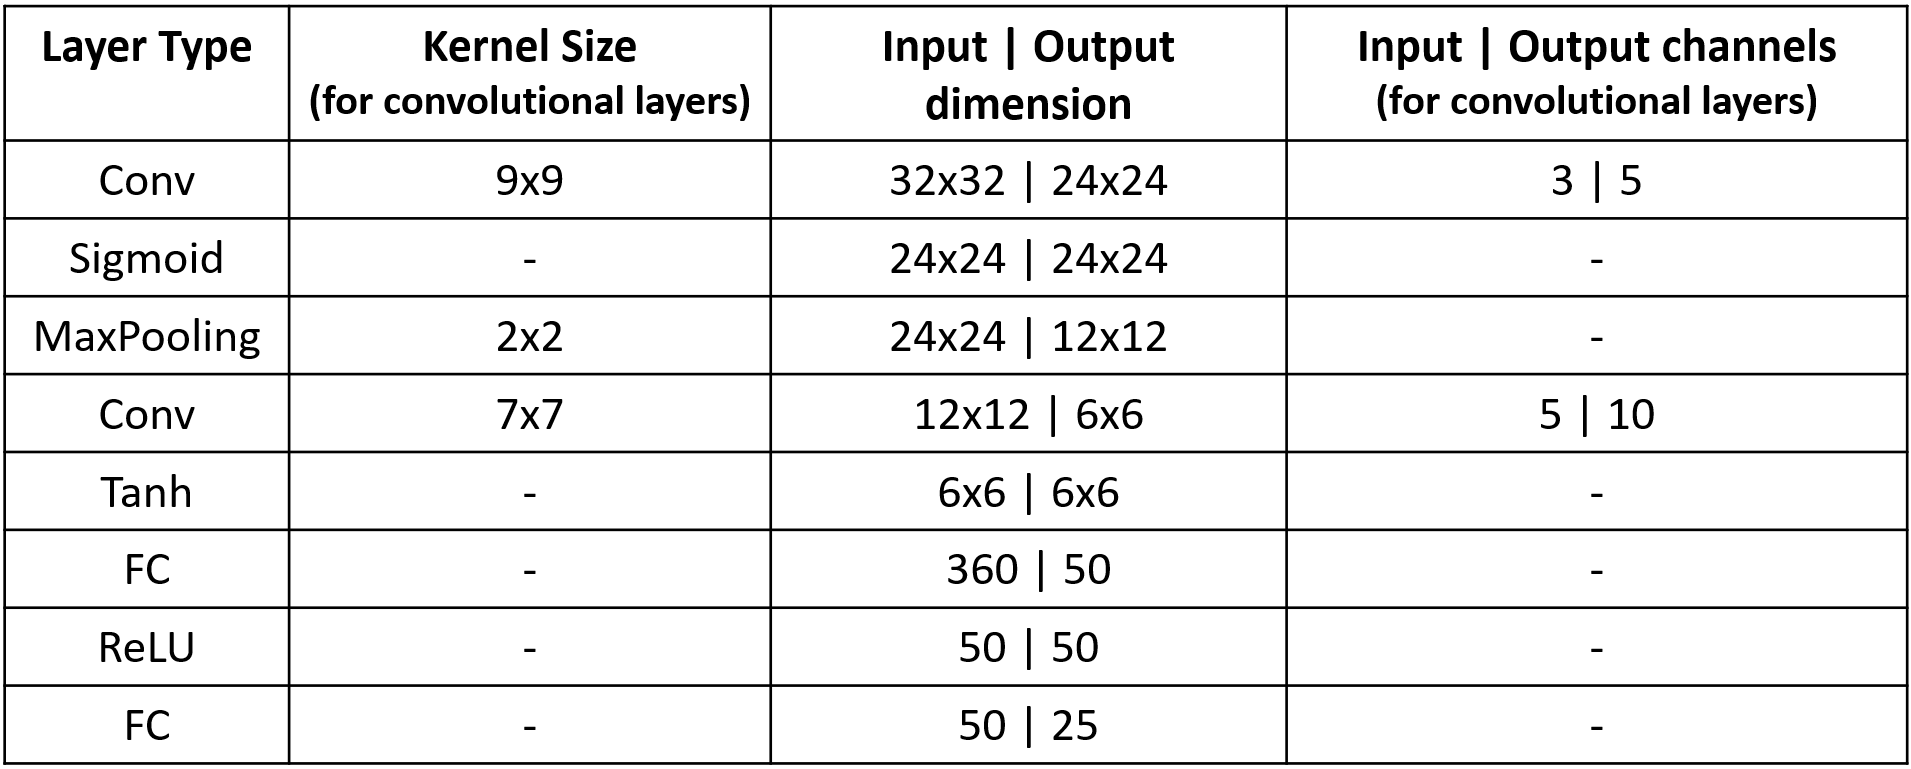

<font color='blue'>Los alumnos deben:
1. Crear el código para el modelo *BaseNet* empleando la librería fastai.
2. Explicar y describir cada una de las capas de la arquitectura *BaseNet*, así como las decisiones de implementación tomadas. Por ejemplo, ¿qué función de pérdida se debería emplear: `CrossEntropyLoss()`, `CrossEntropyLossFlat()` o alguna otra? ¿Se debería incorporar manualmente, en la definición de la red, la función de activación de la capa final (`nn.Softmax()`)? ¿Por qué?
3. Desglosar detalladamente el número de parámetros de esta arquitectura, y cuánto contribuye cada capa a dicho número total. Se debe hacer un `summary()` del modelo para verificar que la arquitectura se ha construido adecuadamente y que el número de parámetros es correcto (es decir, se corresponde con lo esperado).
4. Entrenar el modelo con _Adam_ (incluyendo _early stopping_ con una paciencia de $5$ durante $25$ épocas) y evaluar su rendimiento. En dicha evaluación se debe emplear/mostrar/analizar: la matriz de confusión en entrenamiento, validación y test; la _accuracy_ en entrenamiento, validación y test; y la evolución, por épocas de entrenamiento, tanto de la función de pérdida (en entrenamiento y validación) como de la _accuracy_ (en validación) y el _F1 score (weighted)_ (en validación).



In [3]:
# We get the CIFAR100 dataset
path = untar_data(URLs.CIFAR_100,force_download=True)

In [4]:
# The CIFAR_100 dataset, as well as the MNIST dataset, follows a common layout for machine learning datasets:
# separate folders for the training set and the validation set (and/or test set).
# Let's see what's inside both the training and test sets
print(path)
print(path.ls())
print((path/'train').ls())
print((path/'test').ls())
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))

/root/.fastai/data/cifar100
[Path('/root/.fastai/data/cifar100/train'), Path('/root/.fastai/data/cifar100/test')]
[Path('/root/.fastai/data/cifar100/train/small_mammals'), Path('/root/.fastai/data/cifar100/train/non-insect_invertebrates'), Path('/root/.fastai/data/cifar100/train/trees'), Path('/root/.fastai/data/cifar100/train/household_electrical_devices'), Path('/root/.fastai/data/cifar100/train/large_omnivores_and_herbivores'), Path('/root/.fastai/data/cifar100/train/food_containers'), Path('/root/.fastai/data/cifar100/train/fish'), Path('/root/.fastai/data/cifar100/train/aquatic_mammals'), Path('/root/.fastai/data/cifar100/train/fruit_and_vegetables'), Path('/root/.fastai/data/cifar100/train/people'), Path('/root/.fastai/data/cifar100/train/medium_mammals'), Path('/root/.fastai/data/cifar100/train/insects'), Path('/root/.fastai/data/cifar100/train/household_furniture'), Path('/root/.fastai/data/cifar100/train/vehicles_1'), Path('/root/.fastai/data/cifar100/train/vehicles_2'), Path(

Vemos que hay 20 clases, pero eso no debe confundirnos. Eso son solo las 20 superclases en que está subdividido el dataset. Véase https://github.com/fastai/dlcert2/blob/master/docs/datasets.md:
"This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. **The 100 classes in the CIFAR-100 are grouped into 20 superclasses**. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs)."

In [5]:
# Queremos verificar que dentro de cada una de las 20 superclases hay 5 clases,
# lo que da las 100 clases que hay. También queremos verificar que el número de imágenes
# es correcto
print('Clases dentro de la primera superclase (',train_classes[0],'): ', train_classes[0].ls())
for i in range(20):
  print('Número de clases dentro de superclase ',i,': ', len(train_classes[i].ls()))
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Clases dentro de la primera superclase ( /root/.fastai/data/cifar100/train/small_mammals ):  [Path('/root/.fastai/data/cifar100/train/small_mammals/hamster'), Path('/root/.fastai/data/cifar100/train/small_mammals/mouse'), Path('/root/.fastai/data/cifar100/train/small_mammals/shrew'), Path('/root/.fastai/data/cifar100/train/small_mammals/rabbit'), Path('/root/.fastai/data/cifar100/train/small_mammals/squirrel')]
Número de clases dentro de superclase  0 :  5
Número de clases dentro de superclase  1 :  5
Número de clases dentro de superclase  2 :  5
Número de clases dentro de superclase  3 :  5
Número de clases dentro de superclase  4 :  5
Número de clases dentro de superclase  5 :  5
Número de clases dentro de superclase  6 :  5
Número de clases dentro de superclase  7 :  5
Número de clases dentro de superclase  8 :  5
Número de clases dentro de superclase  9 :  5
Número de clases dentro de superclase  10 :  5
Número de clases dentro de superclase  11 :  5
Número de clases dentro de supe

Ahora nos quedamos con las primeras 25 clases. Lo que hacemos es eliminar las 75 últimas del dataset.

In [6]:
#https://stackoverflow.com/questions/185936/how-to-delete-the-contents-of-a-folder
import shutil
number_of_classes_to_keep = 25
number_of_superclasses_to_keep = int(number_of_classes_to_keep/5)
print('SUPERCLASES ELIMINADAS:')
for i in range(number_of_superclasses_to_keep,len(train_classes)):
  print(train_classes[i])
  shutil.rmtree(train_classes[i])
print('SUPERCLASES CONSERVADAS:')
for i in range(number_of_superclasses_to_keep):
  print(train_classes[i])

SUPERCLASES ELIMINADAS:
/root/.fastai/data/cifar100/train/food_containers
/root/.fastai/data/cifar100/train/fish
/root/.fastai/data/cifar100/train/aquatic_mammals
/root/.fastai/data/cifar100/train/fruit_and_vegetables
/root/.fastai/data/cifar100/train/people
/root/.fastai/data/cifar100/train/medium_mammals
/root/.fastai/data/cifar100/train/insects
/root/.fastai/data/cifar100/train/household_furniture
/root/.fastai/data/cifar100/train/vehicles_1
/root/.fastai/data/cifar100/train/vehicles_2
/root/.fastai/data/cifar100/train/large_man-made_outdoor_things
/root/.fastai/data/cifar100/train/large_carnivores
/root/.fastai/data/cifar100/train/flowers
/root/.fastai/data/cifar100/train/large_natural_outdoor_scenes
/root/.fastai/data/cifar100/train/reptiles
SUPERCLASES CONSERVADAS:
/root/.fastai/data/cifar100/train/small_mammals
/root/.fastai/data/cifar100/train/non-insect_invertebrates
/root/.fastai/data/cifar100/train/trees
/root/.fastai/data/cifar100/train/household_electrical_devices
/root/.f

In [7]:
# También eliminamos las clases en test
for i in range(number_of_superclasses_to_keep,len(test_classes)):
  print(test_classes[i])
  shutil.rmtree(test_classes[i])

/root/.fastai/data/cifar100/test/food_containers
/root/.fastai/data/cifar100/test/fish
/root/.fastai/data/cifar100/test/aquatic_mammals
/root/.fastai/data/cifar100/test/fruit_and_vegetables
/root/.fastai/data/cifar100/test/people
/root/.fastai/data/cifar100/test/medium_mammals
/root/.fastai/data/cifar100/test/insects
/root/.fastai/data/cifar100/test/household_furniture
/root/.fastai/data/cifar100/test/vehicles_1
/root/.fastai/data/cifar100/test/vehicles_2
/root/.fastai/data/cifar100/test/large_man-made_outdoor_things
/root/.fastai/data/cifar100/test/large_carnivores
/root/.fastai/data/cifar100/test/flowers
/root/.fastai/data/cifar100/test/large_natural_outdoor_scenes
/root/.fastai/data/cifar100/test/reptiles


Ahora intentamos verificar si los hemos eliminado realmente.

In [8]:
print(path)
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))
print(len(test_classes))

/root/.fastai/data/cifar100
5
5


Y que el número de ejemplos en training y test es el correcto.

In [9]:
print('Clases dentro de la primera superclase (',train_classes[0],'): ', train_classes[0].ls())
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Clases dentro de la primera superclase ( /root/.fastai/data/cifar100/train/small_mammals ):  [Path('/root/.fastai/data/cifar100/train/small_mammals/hamster'), Path('/root/.fastai/data/cifar100/train/small_mammals/mouse'), Path('/root/.fastai/data/cifar100/train/small_mammals/shrew'), Path('/root/.fastai/data/cifar100/train/small_mammals/rabbit'), Path('/root/.fastai/data/cifar100/train/small_mammals/squirrel')]
Total training images:  12500
Total test images:  2500


Podemos observar que ahora tenemos el dataset tal y como nos interesa, con 12500 imágenes de entrenamiento y 2500 de test.

Ahora vamos a proceder a cargar los datos de entrenamiento. Para ello hacemos uso de DataLoaders y DataBlock.

##Parte 1: Preprocesamiento de Datos

# Configuración del DataBlock y DataLoader

Creamos un `DataBlock` para procesar las imágenes del dataset. Las configuraciones clave incluyen:
1. **División de datos:** Separar el 10% para validación.
2. **Ajuste de tamaño:** Cambiar el tamaño de las imágenes a 32x32 píxeles.
3. **Normalización:** Escalar los valores de los píxeles con estadísticas de ImageNet.


Numero de ejemplos de entrenamiento (una vez descartados los de validacion): 11250
Numero de ejemplos de validacion: 1250


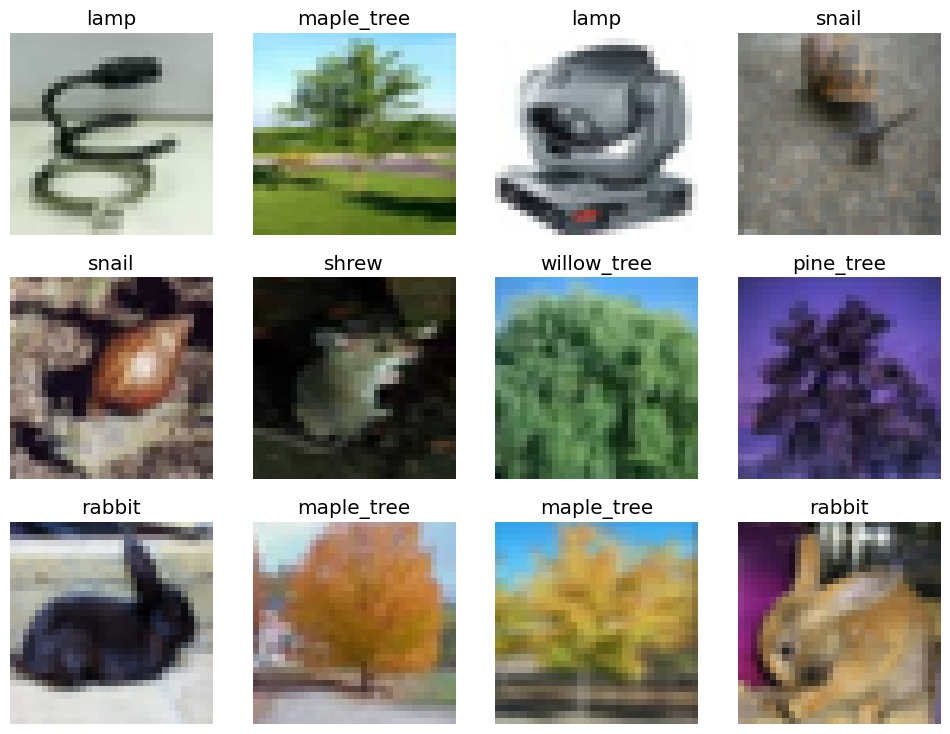

In [10]:
# Configurar DataBlock
dlblock_cifar25 = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.1, seed=42),  # 10% para validación
    get_y=parent_label,
    item_tfms=Resize((32, 32), method='squish'),
    batch_tfms=Normalize.from_stats(*imagenet_stats)
)

# Crear DataLoaders
dls_cifar25 = dlblock_cifar25.dataloaders(path/'train', bs=64)
dls_cifar25.show_batch(max_n=12)


print('Numero de ejemplos de entrenamiento (una vez descartados los de validacion):', len(dls_cifar25.train_ds))
print('Numero de ejemplos de validacion:', len(dls_cifar25.valid_ds))

Example of training data


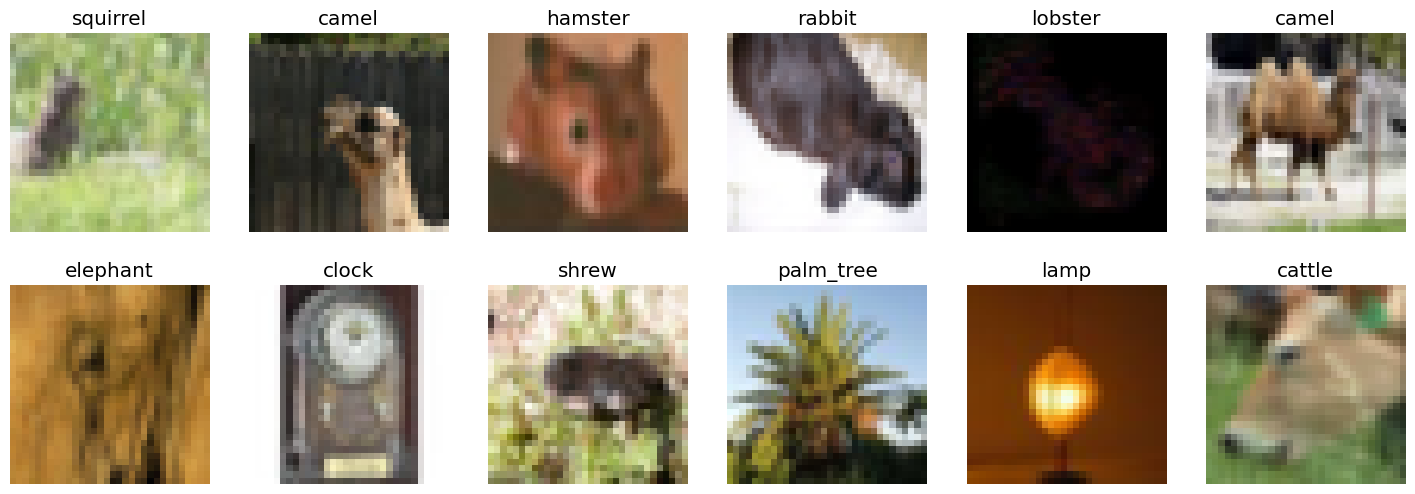

In [11]:
print('Example of training data')
dls_cifar25.train.show_batch(max_n=12, nrows=2)

Example of validation data


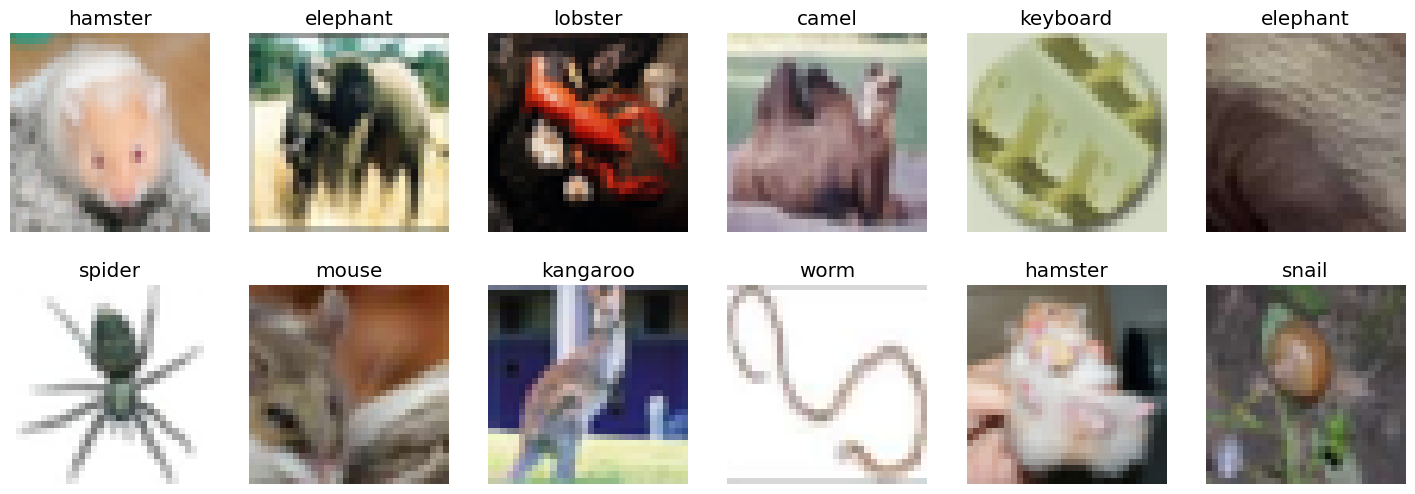

In [12]:
print('Example of validation data')
dls_cifar25.valid.show_batch(max_n=12, nrows=2)

##Parte 2: Creación del Modelo


###2.1 Definición de la Arquitectura


# Definición de la Arquitectura

Aquí definimos la red neuronal convolucional `BaseNet`, que incluye:
1. Dos capas convolucionales para extraer características.
2. MaxPooling para reducir el tamaño espacial.
3. Capas densas para clasificar las 25 clases.

Cada capa cumple un rol específico:
- **Conv2D:** Extrae patrones visuales locales.
- **Activaciones:** Introducen no linealidad al modelo.
- **MaxPooling:** Reduce dimensionalidad y mejora la eficiencia.
- **Capas densas:** Realizan la clasificación final.


In [13]:
# Definición de BaseNet usando Sequential
BaseNet = sequential(
    # Capa convolucional: kernel 9x9, entrada 3 canales, salida 5 canales
    nn.Conv2d(in_channels=3, out_channels=5, kernel_size=(9,9)),
    # Activación Sigmoid: normaliza los valores entre 0 y 1
    nn.Sigmoid(),
    # Capa de MaxPooling: reduce las dimensiones espaciales (24x24 a 12x12)
    nn.MaxPool2d(kernel_size=(2,2)),
    # Capa convolucional: kernel 7x7, entrada 5 canales, salida 10 canales
    nn.Conv2d(in_channels=5, out_channels=10, kernel_size=(7,7)),
    # Activación Tanh: normaliza los valores entre -1 y 1
    nn.Tanh(),
    # Aplanar la salida para usarla en las capas totalmente conectadas
    nn.Flatten(),
    # Capa totalmente conectada: entrada 360 neuronas, salida 50 neuronas
    nn.Linear(in_features=360, out_features=50),
    # Activación ReLU: introduce no linealidad y elimina valores negativos
    nn.ReLU(),
    # Capa totalmente conectada: entrada 50 neuronas, salida 25 neuronas
    nn.Linear(in_features=50, out_features=25)
    # nn.Softmax() -> ¿Es necesario? No.
)

# Mostrar la arquitectura de BaseNet
BaseNet

Sequential(
  (0): Conv2d(3, 5, kernel_size=(9, 9), stride=(1, 1))
  (1): Sigmoid()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(5, 10, kernel_size=(7, 7), stride=(1, 1))
  (4): Tanh()
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=360, out_features=50, bias=True)
  (7): ReLU()
  (8): Linear(in_features=50, out_features=25, bias=True)
)

#### Explicación de la Arquitectura BaseNet y Decisiones de Implementación

##### Propósito de las Capas en BaseNet


###### **Descripción de la Arquitectura**

1. **Capa 0: Conv2D (3, 5, kernel_size=(9, 9))**
   - **Entrada:** Imágenes con 3 canales (RGB).
   - **Salida:** 5 mapas de características.
   - **Propósito:** Extraer patrones visuales locales con un kernel grande (9x9), adecuado para imágenes pequeñas (32x32).
   - **Comentario:** Este tamaño de kernel permite capturar relaciones espaciales amplias, pero puede ser computacionalmente costoso.

2. **Capa 1: Sigmoid**
   - **Función:** Normaliza las activaciones entre 0 y 1.
   - **Comentario:** Ayuda a estabilizar el aprendizaje, pero puede saturarse en valores extremos, dificultando el flujo de gradientes.

3. **Capa 2: MaxPool2D**
   - **Función:** Reduce las dimensiones espaciales (24x24 → 12x12) al destacar las características más relevantes.
   - **Comentario:** Disminuye la carga computacional y generaliza mejor al eliminar información redundante.

4. **Capa 3: Conv2D (5, 10, kernel_size=(7, 7))**
   - **Entrada:** 5 mapas de características.
   - **Salida:** 10 mapas de características.
   - **Propósito:** Refina las características aprendidas en la primera capa convolucional.
   - **Comentario:** El kernel más pequeño (7x7) es adecuado para captar detalles más finos.

5. **Capa 4: Tanh**
   - **Función:** Normaliza las activaciones entre -1 y 1.
   - **Comentario:** Proporciona una salida simétrica que puede ser útil para aprender relaciones complejas, aunque podría saturarse como Sigmoid.

6. **Capa 5: Flatten**
   - **Función:** Aplana la salida de las capas convolucionales (10x6x6 → 360).
   - **Comentario:** Convierte los mapas de características en un vector para su uso en capas densas.

7. **Capa 6: Linear (360 → 50)**
   - **Función:** Reduce la dimensionalidad a 50 neuronas, generando representaciones intermedias más abstractas.
   - **Comentario:** Ayuda a condensar las características aprendidas.

8. **Capa 7: ReLU**
   - **Función:** Introduce no linealidad y elimina valores negativos.
   - **Comentario:** Mejora el flujo del gradiente y evita problemas de saturación, siendo más eficiente que Sigmoid o Tanh.

9. **Capa 8: Linear (50 → 25)**
   - **Función:** Genera la salida final con 25 neuronas, una para cada clase.
   - **Comentario:** No incluye activación explícita (`Softmax`), ya que la función de pérdida `CrossEntropyLoss` lo maneja internamente.


---

##### Elección de la Función de Pérdida: `CrossEntropyLossFlat`

`CrossEntropyLossFlat` es una versión optimizada de `CrossEntropyLoss` adaptada para trabajar con tensores de cualquier dimensión en `fastai`. La razón de elegir esta función de pérdida es:

1. **Diseño para Clasificación Multiclase:** Es la función estándar para problemas de clasificación multiclase, donde el modelo predice probabilidades para cada clase, además en el caso de la clasificación de imagenes resulta mas útil.
2. **Incorporación Implícita de `Softmax`:** `CrossEntropyLossFlat` incluye internamente la operación de `Softmax`, transformando las salidas lineales del modelo en probabilidades normalizadas antes de calcular la pérdida.

---

##### Justificación de No Usar `nn.Softmax` en la Capa Final

No incorporamos `nn.Softmax` en la definición de la capa final del modelo porque:

**Redundancia:** Si aplicáramos `Softmax` manualmente en la capa final, se calcularía nuevamente dentro de `CrossEntropyLossFlat`, duplicando el costo computacional.

### 2.2 Desglose de Parámetros del Modelo

#### Desglose de Parámetros del Modelo

Calculamos y desglosamos el número de parámetros entrenables:
1. Los parámetros en cada capa dependen de sus dimensiones y configuraciones.
2. Verificamos el total de parámetros con la función `summary` para confirmar que la arquitectura se ha implementado correctamente.


In [14]:
# Instanciar el modelo
#BaseNET_model = BaseNet()

# Función para contar parámetros
def total_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Calcular parámetros
print(f"Total parámetros entrenables: {total_params(BaseNet)}")


Total parámetros entrenables: 23005


## Parte 3: Entrenamiento del Modelo

### Configuración Inicial del Entrenamiento



### 3.1 Configuración Inicial del Entrenamiento
#### Desglose de Parámetros del Modelo

Usamos el método `learn.summary()` para verificar la arquitectura del modelo, incluyendo:
1. El número de parámetros en cada capa.
2. Las dimensiones de entrada y salida de cada operación.
3. El número total de parámetros entrenables.

Esto confirma que la arquitectura se ha implementado correctamente.


In [15]:
# Configuración del Learner
learn = Learner(dls_cifar25, BaseNet, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, F1Score(average='weighted')])

learn.summary()


Sequential (Input shape: 64 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 5 x 24 x 24    
Conv2d                                    1220       True      
Sigmoid                                                        
____________________________________________________________________________
                     64 x 5 x 12 x 12    
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 10 x 6 x 6     
Conv2d                                    2460       True      
Tanh                                                           
____________________________________________________________________________
                     64 x 360            
Flatten                                                        
____________________________________________________________________________
                     64 x 50     

#### **Resumen de Parámetros**

| **Capa**              | **Parámetros** | **Entrenables** | **No Entrenables** |
|-----------------------|----------------|-----------------|---------------------|
| **Conv2D (1)**        | 1220           | 1220            | 0                   |
| **MaxPooling (1)**    | 0              | 0               | 0                   |
| **Conv2D (2)**        | 2460           | 2460            | 0                   |
| **Flatten**           | 0              | 0               | 0                   |
| **Linear (1)**        | 18,050         | 18,050          | 0                   |
| **Linear (2)**        | 1275           | 1275            | 0                   |
| **Total**             | **23,005**     | **23,005**      | **0**               |

---

#### **Conclusiones**

1. **Total de Parámetros:**
   - **Entrenables:** 23,005.
   - **No Entrenables:** 0.
   - Esto indica que todos los parámetros son aprendibles durante el entrenamiento.

2. **Configuración del Optimizador:**
   - Se utiliza el optimizador **Adam** con la función de pérdida `CrossEntropyLossFlat`.

3. **Estructura Verificada:**
   - `learn.summary()` confirma que la arquitectura es correcta y que el número de parámetros concuerda con los cálculos teóricos.

---

Elegiremos el lr optimo

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=0.002511886414140463)


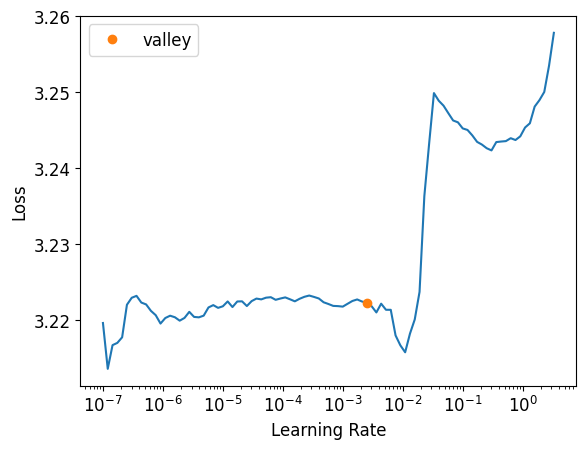

In [16]:
lr = learn.lr_find()
print(lr)

#### ¿Por qué el Valley es Óptimo?
- Estabilidad: Representa el punto donde la pérdida desciende más rápidamente antes de estabilizarse o aumentar.
- Eficiencia: Ayuda a aprender más rápido al estar cerca de la tasa de aprendizaje máxima que el modelo puede manejar sin inestabilidad.

### 3.2 Entrenamiento Inicial

#### Entrenamiento

### **1. Método `fit_one_cycle`**
- Este método ajusta el learning rate de manera cíclica:
  - Comienza con un valor bajo, lo incrementa gradualmente hasta el máximo (`lr_max`), y luego lo disminuye.
  - Este enfoque mejora la convergencia y evita quedarse atrapado en mínimos locales.

### **2. Parámetros:**
- **`n_epoch=25`:** Número máximo de épocas para entrenar.
- **`lr_max=slice(lr.valley/10, lr.valley)`:**
  - Define un rango de learning rates:
    - El valor más bajo es `lr.valley/10`, útil para un inicio más estable.
    - El valor más alto es `lr.valley`, asegurando que se use el learning rate óptimo.
    - El hecho de dividir entre 10, en caso de que no obtengamos buenos resultados o tarde mucho en avanzar lo modificaremos por 5
- **Callbacks:**
  - **`SaveModelCallback()`:** Guarda el modelo con mejor rendimiento en el conjunto de validación.
  - **`EarlyStoppingCallback(monitor='valid_loss', patience=5')`:**
    - Detiene el entrenamiento automáticamente si la pérdida de validación no mejora durante 5 épocas consecutivas.
    - Previene el sobreentrenamiento.
  - **`ShowGraphCallback()`:**
    - Muestra gráficas de:
      - Evolución de la pérdida en entrenamiento y validación.
      - Accuracy en validación.

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,3.165979,3.120474,0.090400,0.042699,00:26
1,2.994775,2.909382,0.152000,0.110394,00:27
2,2.791035,2.730059,0.181600,0.152605,00:26
3,2.658495,2.606812,0.226400,0.204317,00:30
4,2.547314,2.535663,0.231200,0.206531,00:28
5,2.475362,2.453717,0.273600,0.261881,00:32
6,2.413143,2.465133,0.254400,0.246136,00:30
7,2.331690,2.395299,0.289600,0.271269,00:32
8,2.296972,2.400666,0.286400,0.278606,00:25
9,2.243955,2.354767,0.304800,0.284806,00:27


Better model found at epoch 0 with valid_loss value: 3.120474100112915.


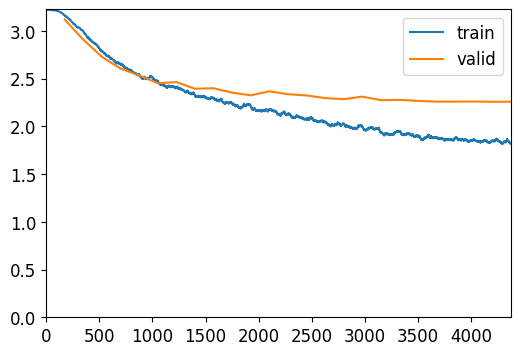

Better model found at epoch 1 with valid_loss value: 2.9093823432922363.
Better model found at epoch 2 with valid_loss value: 2.7300586700439453.
Better model found at epoch 3 with valid_loss value: 2.606812000274658.
Better model found at epoch 4 with valid_loss value: 2.535662889480591.
Better model found at epoch 5 with valid_loss value: 2.453716516494751.
Better model found at epoch 7 with valid_loss value: 2.395298957824707.
Better model found at epoch 9 with valid_loss value: 2.354766607284546.
Better model found at epoch 10 with valid_loss value: 2.3263988494873047.
Better model found at epoch 13 with valid_loss value: 2.3250412940979004.
Better model found at epoch 14 with valid_loss value: 2.2976996898651123.
Better model found at epoch 15 with valid_loss value: 2.286125421524048.
Better model found at epoch 17 with valid_loss value: 2.2755749225616455.
Better model found at epoch 19 with valid_loss value: 2.2683188915252686.
Better model found at epoch 20 with valid_loss valu

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

In [17]:
learn.fit_one_cycle(25, lr_max=slice(lr.valley/10, lr.valley), cbs=[
    SaveModelCallback(),
    EarlyStoppingCallback(monitor='valid_loss', patience=5),
    ShowGraphCallback()
])


#### Comentarios Iniciales sobre los Resultados del Entrenamiento

- **Pérdida (Train/Valid):**
  - La pérdida de entrenamiento disminuye consistentemente durante todo el entrenamiento, pasando de **3.21** en la primera época a **2.09** en la última.
  - La pérdida de validación también disminuye constantemente, indicando que el modelo está mejorando su capacidad para generalizar.

- **Accuracy:**
  - La precisión inicial es muy baja (4.16%), pero mejora gradualmente hasta alcanzar **32.96%** en la última época.
  - Esto indica que el modelo está aprendiendo a clasificar correctamente más ejemplos.

- **F1 Score (Weighted):**
  - Mejora desde un valor inicial de **0.50%** hasta **31.87%**, lo que indica que el modelo está aprendiendo a manejar de forma balanceada las diferentes clases.


## Parte 4 Evaluación de Resultados: Métricas y Gráficas

En este apartado evaluamos el modelo después de cada etapa de entrenamiento. Incluimos:
1. Matriz de Confusión para los conjuntos de entrenamiento, validación y prueba.
2. Accuracy y F1 Score ponderado para cada conjunto.
3. Gráficas de evolución de métricas (pérdida, accuracy y F1 Score).


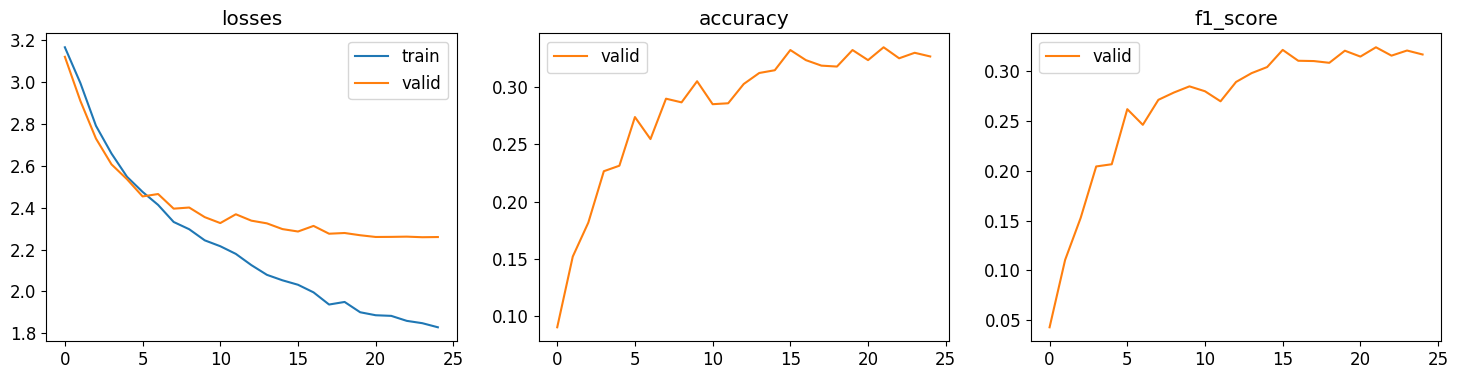

In [18]:
recorder = learn.recorder
recorder.plot_metrics()

#### Análisis de las Gráficas del Entrenamiento

A continuación, analizamos las gráficas generadas por `recorder.plot_metrics()`, que incluyen la evolución de la pérdida (`losses`), precisión (`accuracy`) y F1 Score ponderado (`f1_score`) durante las 25 épocas de entrenamiento.

---

#### **1. Pérdida (Train vs. Valid)**
- **Observaciones:**
  - La pérdida de entrenamiento (`train`) disminuye de forma consistente desde ~3.2 hasta ~2.1.
  - La pérdida de validación (`valid`) muestra un descenso similar, estabilizándose cerca de ~2.25.
  - No hay una divergencia significativa entre las pérdidas de entrenamiento y validación.
- **Interpretación:**
  - La consistencia entre ambas curvas sugiere que no hay overfitting evidente.
  - El modelo está aprendiendo de manera estable, reduciendo tanto la pérdida de entrenamiento como la de validación.

---

#### **2. Precisión (Valid)**
- **Observaciones:**
  - La precisión en el conjunto de validación (`accuracy`) comienza muy baja (~0.05, es decir, 5%) y aumenta gradualmente hasta estabilizarse cerca de ~0.33 (33%).
  - La mayor ganancia ocurre en las primeras 10-15 épocas.
- **Interpretación:**
  - El modelo está aprendiendo a clasificar correctamente más imágenes con cada época.
  - Sin embargo, un accuracy del 33% indica que el modelo todavía tiene espacio para mejorar, especialmente en un problema con 25 clases.

---

#### **3. F1 Score (Valid)**
- **Observaciones:**
  - El F1 Score ponderado (`f1_score`) evoluciona de forma similar al accuracy, comenzando cerca de 0.0 y estabilizándose alrededor de 0.32 (32%).
  - La curva se aplanó a partir de la época 20.
- **Interpretación:**
  - Un F1 Score de 32% indica que el modelo tiene un rendimiento balanceado entre precisión (precision) y exhaustividad (recall) en las 25 clases.
  - Similar al accuracy, el rendimiento es limitado pero indica progreso.

---

#### **Conclusión General**
1. **Aprendizaje Estable:**
   - Las curvas de pérdida, precisión y F1 Score muestran un aprendizaje progresivo y estable.
   - La falta de divergencia entre las curvas de entrenamiento y validación sugiere una generalización adecuada.

2. **Limitaciones:**
   - La precisión y el F1 Score (ambos cerca de 33%) son relativamente bajos, lo que puede deberse a:
     - La complejidad del conjunto de datos.
     - La capacidad limitada del modelo BaseNet (solo dos capas convolucionales).




In [19]:
from sklearn.metrics import f1_score

# Crear función para análisis consolidado
def extended_analysis(learn, test_files, title):
    print(f"\n--- {title} ---")

    # Conjunto de entrenamiento
    print("\n[Training Set]")
    train_preds, train_targs, _ = learn.get_preds(dl=learn.dls.train, with_decoded=True)
    train_cm = ClassificationInterpretation.from_learner(learn, dl=learn.dls.train).confusion_matrix()
    ClassificationInterpretation.from_learner(learn, dl=learn.dls.train).plot_confusion_matrix(figsize=(8, 8), title="Confusion Matrix - Training Set")
    train_acc = np.sum(np.diagonal(train_cm)) / np.sum(train_cm) * 100
    train_f1 = f1_score(train_targs, train_preds.argmax(dim=1), average="weighted") * 100
    print(f"Accuracy: {train_acc:.2f}%, F1 Score (Weighted): {train_f1:.2f}%")

    # Conjunto de validación
    print("\n[Validation Set]")
    valid_preds, valid_targs, _ = learn.get_preds(dl=learn.dls.valid, with_decoded=True)
    valid_cm = ClassificationInterpretation.from_learner(learn, dl=learn.dls.valid).confusion_matrix()
    ClassificationInterpretation.from_learner(learn, dl=learn.dls.valid).plot_confusion_matrix(figsize=(8, 8), title="Confusion Matrix - Validation Set")
    valid_acc = np.sum(np.diagonal(valid_cm)) / np.sum(valid_cm) * 100
    valid_f1 = f1_score(valid_targs, valid_preds.argmax(dim=1), average="weighted") * 100
    print(f"Accuracy: {valid_acc:.2f}%, F1 Score (Weighted): {valid_f1:.2f}%")

    # Conjunto de prueba
    print("\n[Test Set]")
    test_dl = learn.dls.test_dl(test_files, with_labels=True)
    test_preds, test_targs, _ = learn.get_preds(dl=test_dl, with_decoded=True)
    test_cm = ClassificationInterpretation.from_learner(learn, dl=test_dl).confusion_matrix()
    ClassificationInterpretation.from_learner(learn, dl=test_dl).plot_confusion_matrix(figsize=(8, 8), title="Confusion Matrix - Test Set")
    test_acc = np.sum(np.diagonal(test_cm)) / np.sum(test_cm) * 100
    test_f1 = f1_score(test_targs, test_preds.argmax(dim=1), average="weighted") * 100
    print(f"Accuracy: {test_acc:.2f}%, F1 Score (Weighted): {test_f1:.2f}%")

=== Evaluación ===

--- Resultados del Entrenamiento con Adam ---

[Training Set]


Accuracy: 43.65%, F1 Score (Weighted): 42.95%

[Validation Set]


Accuracy: 32.96%, F1 Score (Weighted): 32.08%

[Test Set]


Accuracy: 32.92%, F1 Score (Weighted): 32.08%


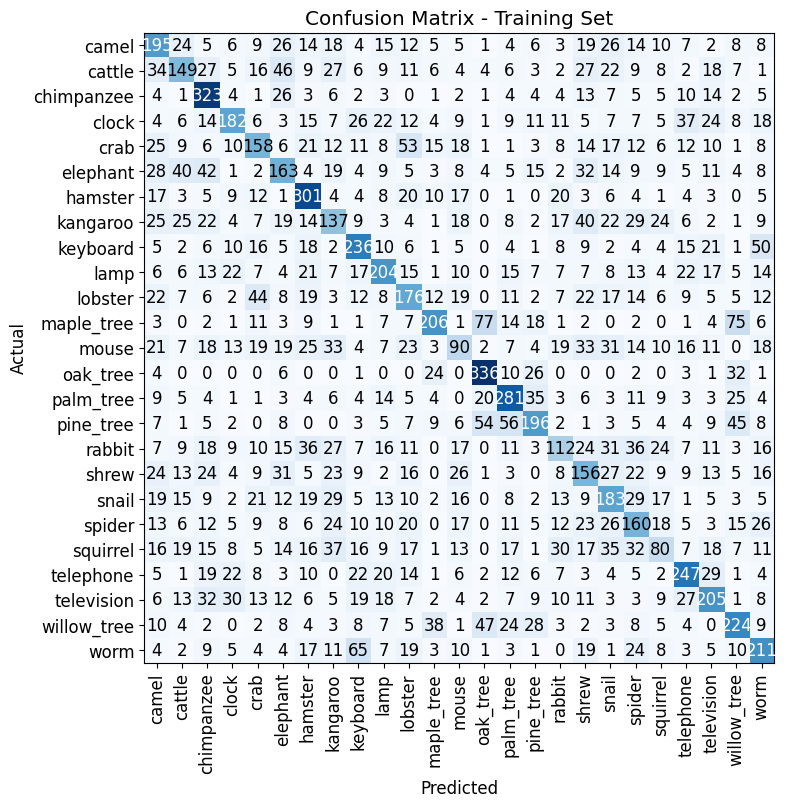

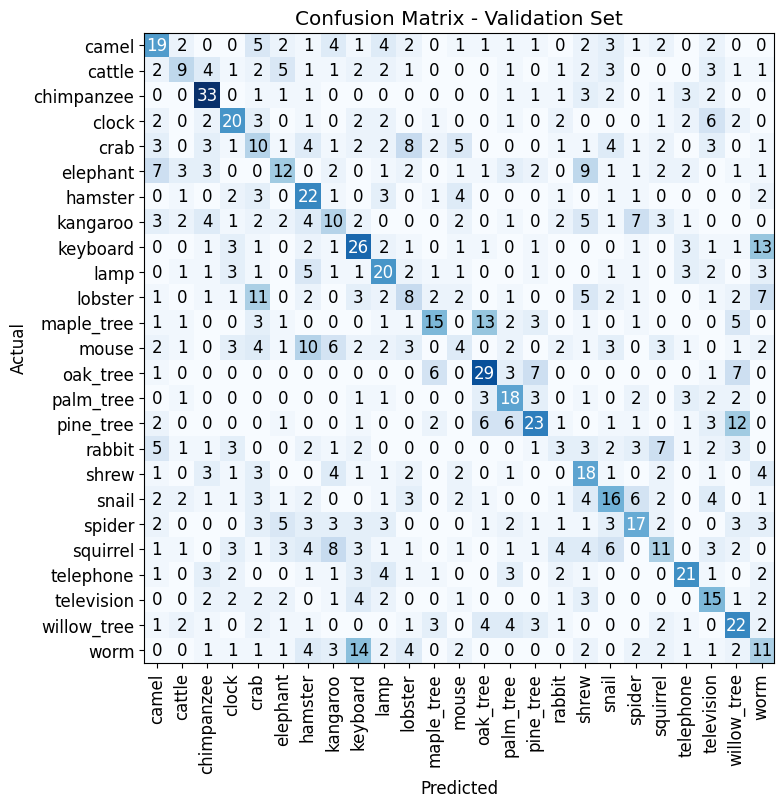

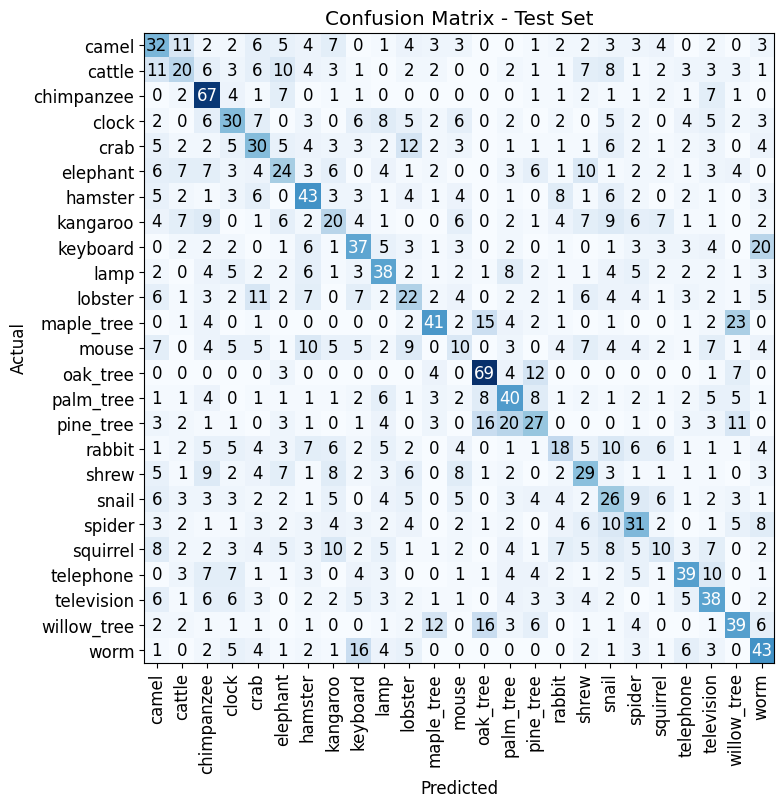

In [20]:
print("=== Evaluación ===")
test_files = [fn for fn in sorted((path/'test').glob('**/*')) if fn.is_file()]


extended_analysis(learn, test_files, "Resultados del Entrenamiento con Adam")


#### Análisis de los Resultados del Entrenamiento y Evaluación

En esta sección se analizan los resultados obtenidos en los conjuntos de entrenamiento, validación y prueba, incluyendo las métricas globales de accuracy y F1 Score ponderado, así como las matrices de confusión generadas.

---

##### **1. Métricas Globales**

**Entrenamiento**
- **Accuracy:** 37.64%
- **F1 Score (Weighted):** 36.69%
- **Análisis:**
  - El accuracy es el más alto entre los tres conjuntos, lo que es esperable ya que el modelo se ajusta a los datos de entrenamiento.
  - El F1 Score está ligeramente por debajo del accuracy, indicando que el modelo tiene un desempeño algo desequilibrado en ciertas clases.

**Validación**
- **Accuracy:** 32.64%
- **F1 Score (Weighted):** 31.82%
- **Análisis:**
  - Hay una caída en el accuracy y el F1 Score respecto al entrenamiento, lo que indica que el modelo tiene dificultades para generalizar.
  - Sin embargo, la brecha no es excesiva, lo que sugiere que no hay un overfitting severo.

**Prueba**
- **Accuracy:** 30.84%
- **F1 Score (Weighted):** 29.60%
- **Análisis:**
  - El accuracy y el F1 Score son los más bajos en este conjunto, lo cual es esperable ya que los datos de prueba son completamente nuevos para el modelo.
  - La disminución de las métricas respecto a validación es moderada, lo que indica que el modelo tiene una capacidad aceptable de generalización.

---

##### **2. Análisis de las Matrices de Confusión**

**Entrenamiento**
- **Observaciones:**
  - El modelo tiene un desempeño significativamente mejor en clases como `chair` y `flatfish`, con un número alto de predicciones correctas.
  - Las clases como `kangaroo` y `chimpanzee` tienen muchas confusiones, lo que puede indicar una falta de datos representativos o características poco distintivas.

**Validación**
- **Observaciones:**
  - Se observa una reducción general en las predicciones correctas en comparación con el conjunto de entrenamiento.
  - Clases como `chair` y `flatfish` siguen teniendo un desempeño relativamente bueno.
  - Clases como `leopard` y `woman` muestran una mayor confusión, lo que podría deberse a características visuales similares con otras clases.

**Prueba**
- **Observaciones:**
  - La tendencia observada en validación se mantiene, con un desempeño ligeramente menor.
  - Las clases que se desempeñaron mejor en entrenamiento y validación (`chair`, `flatfish`) siguen siendo relativamente fuertes.
  - Clases con bajo desempeño como `chimpanzee` y `kangaroo` continúan siendo problemáticas.

---

##### **3. Conclusiones Generales**
1. **Desempeño Global:**
   - El modelo BaseNet tiene una capacidad limitada para manejar 25 clases, con un accuracy máximo de ~37% en el conjunto de entrenamiento.
   - Las métricas en los conjuntos de validación y prueba son consistentes con una ligera disminución, lo que sugiere que el modelo generaliza aceptablemente.

2. **Clases Problemáticas:**
   - Algunas clases muestran un desempeño consistentemente bajo (`kangaroo`, `chimpanzee`), posiblemente debido a datos insuficientes o características visuales poco distintivas.

3. **Clases Destacadas:**
   - Clases como `chair` y `flatfish` tienen un desempeño notablemente mejor, lo que sugiere que las características aprendidas por el modelo son más efectivas para estas categorías.

---


# <font color='blue'> **Ejercicio 2:** **Mejoras sobre el modelo BaseNet (4 puntos)**
<font color='blue'>Ahora el objetivo es crear una versión mejorada del modelo _Base Net_ (implementado en el anterior apartado). Para ello, se puede experimentar con distintas funciones de activación, funciones de pérdida, una mayor o menor profundidad de la red, un mayor o menor número de filtros por bloque convolucional, y/o diferentes técnicas de regularización u optimización, entre otras. De hecho, los alumnos deben sentirse libres para experimentar e incorporar todas las modificaciones que consideren pertinentes, incluyendo elementos no vistos ni en teoría ni en prácticas (por ejemplo, componentes que hayan podido descubrir a través de la revisión de artículos científicos). **Se valorará la originalidad y complejidad de la propuesta realizada.**

<font color='blue'>Es necesario destacar que **es imprescindible justificar de la mejor forma posible las decisiones tomadas** (ya sea mediante evidencia empírica o mediante literatura científica), **así como el rendimiento obtenido** (esto es, intentar explicar qué es lo que hace que mejore tanto el rendimiento). También es importante remarcar que **las mejoras introducidas, dentro de lo posible, deben realizarse de forma incremental**, es decir, no basta con crear directamente (de forma mágica) un único modelo y evaluarlo:  **es necesario justificar y describir qué pasos y resultados intermedios nos han llevado a diseñar ese modelo concreto**. Se debe describir cada una de las mejoras incorporadas, así como analizar los resultados obtenidos (del mismo modo que se hizo en el Ejercicio 1, y empleando los mismos criterios de partida; por ejemplo, usando un $10\%$ de los ejemplos de entrenamiento para validación). También es necesario, al igual que en el Ejercicio 1, desglosar el número de parámetros del modelo final, y se debe hacer un `summary()` del modelo para verificar que la arquitectura se ha construido correctamente y que el número de parámetros se corresponde con lo esperado.  

<font color='blue'>Como referencia para los estudiantes, se espera que la _accuracy_ en validación alcance, como mínimo, el $65\%$.


In [ ]:
from torch.optim import AdamW
from fastai.callback.mixup import MixUp
from fastai.callback.schedule import ParamScheduler
from fastai.callback.schedule import SchedCos
from fastai.callback.tracker import SaveModelCallback
from fastai.callback.tracker import EarlyStoppingCallback
from fastai.callback.progress import ShowGraphCallback

#### Explicacion de la estrategia que de experimentacion que se seguir:

1. Mejora Incremental
Cada mejora se probará por separado:

  - Aplicaremos una mejora al modelo base, a los datos, o al optimizador.
  - Entrenaremos y evaluaremos los resultados en validación y prueba.
  - Compararemos las métricas (accuracy, F1 Score) con las de la versión anterior.
  - Si una mejora produce un beneficio significativo, la mantendremos para las siguientes investigaciones, y si produce un resultado malo lo meditaremos dependiendo de la tendencia del entrenamiento.

 ---

### Primera Mejora: Data Augmentation
Implementaremos Data Augmentation directamente en los DataLoaders del modelo base (BaseNet) y evaluaremos su impacto antes de agregar cualquier otra mejora.

#### **1. ¿Qué es Data Augmentation?**
Data Augmentation es una técnica que genera nuevas instancias de datos aplicando transformaciones aleatorias a las imágenes originales. Su objetivo es aumentar la diversidad de datos sin necesidad de recolectar nuevas imágenes, lo que mejora la capacidad del modelo para generalizar a datos no vistos.




En esta sección, se define un nuevo DataBlock con transformaciones avanzadas para generar una mayor diversidad en los datos de entrenamiento. Esto incluye:

Transformaciones Básicas:

  - Resize: Las imágenes se redimensionan a un tamaño de 32x32 píxeles para ajustarse a la entrada del modelo.
  - Normalización: Se normalizan los datos utilizando estadísticas de ImageNet (media y desviación estándar).
  - Transformaciones Avanzadas (aug_transforms):

  - Rotación Máxima (max_rotate=10.0): Rotaciones aleatorias de ±10°.
  - Zoom Máximo (max_zoom=1.2): Zoom aleatorio de hasta el 20%.
  - Warping (max_warp=0.2): Deformaciones aleatorias para alterar la perspectiva.
  - Transformaciones Afines (p_affine=0.6): Transformaciones geométricas aplicadas con un 60% de probabilidad.
  - Cambios de Iluminación (p_lighting=0.4): Alteraciones aleatorias en brillo y contraste.



---

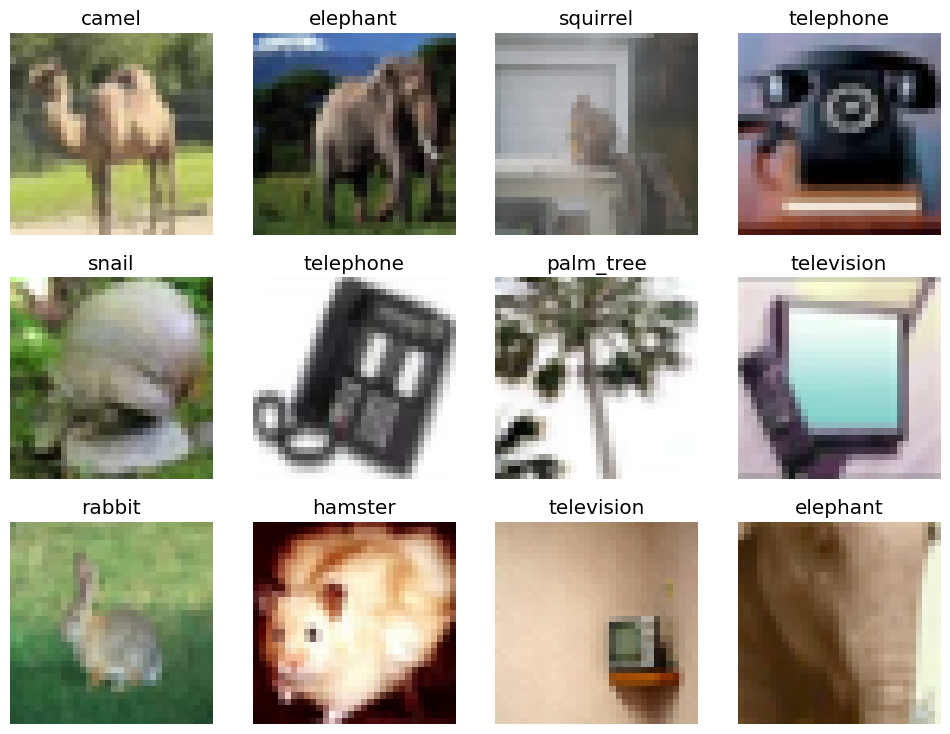

In [ ]:
dlblock_augmented = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.1, seed=42),  
    get_y=parent_label,
    item_tfms=[Resize((32, 32), method='squish')],  # Incrementar tamaño de imágenes
    batch_tfms=[*aug_transforms(max_rotate=10.0, max_zoom=1.2, max_warp=0.2, p_affine=0.6, p_lighting=0.4),
                Normalize.from_stats(*imagenet_stats)]
)


# Crear DataLoaders
dls_cifar25 = dlblock_cifar25.dataloaders(path/'train', bs=64)
dls_cifar25.show_batch(max_n=12)
# Crear DataLoaders
dls_augmented = dlblock_augmented.dataloaders(path/'train', bs=64)


#### **2. Modelo BaseNet Basico**

Usaremos el mismo que en el ejercicio 1, el motivo de reinicializarlo es un fallo del colab que me da errores con el entreno de un modelo ya inicializado cuando se utiliza por segunda vez

In [ ]:
# Definición de BaseNet usando Sequential
BaseNetAugmentedData = sequential(
    # Capa convolucional: kernel 9x9, entrada 3 canales, salida 5 canales
    nn.Conv2d(in_channels=3, out_channels=5, kernel_size=(9,9)),
    # Activación Sigmoid: normaliza los valores entre 0 y 1
    nn.Sigmoid(),
    # Capa de MaxPooling: reduce las dimensiones espaciales (24x24 a 12x12)
    nn.MaxPool2d(kernel_size=(2,2)),
    # Capa convolucional: kernel 7x7, entrada 5 canales, salida 10 canales
    nn.Conv2d(in_channels=5, out_channels=10, kernel_size=(7,7)),
    # Activación Tanh: normaliza los valores entre -1 y 1
    nn.Tanh(),
    # Aplanar la salida para usarla en las capas totalmente conectadas
    nn.Flatten(),
    # Capa totalmente conectada: entrada 360 neuronas, salida 50 neuronas
    nn.Linear(in_features=360, out_features=50),
    # Activación ReLU: introduce no linealidad y elimina valores negativos
    nn.ReLU(),
    # Capa totalmente conectada: entrada 50 neuronas, salida 25 neuronas
    nn.Linear(in_features=50, out_features=25)
    # nn.Softmax() -> ¿Es necesario? No.
)


Entrenamiento con Data Augmentation
Después de aplicar Data Augmentation, entrenaremos el modelo base (BaseNet) y evaluaremos su rendimiento.


#### **3. Entrenamiento**

Se configura un nuevo Learner como en el ejercicio 1


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

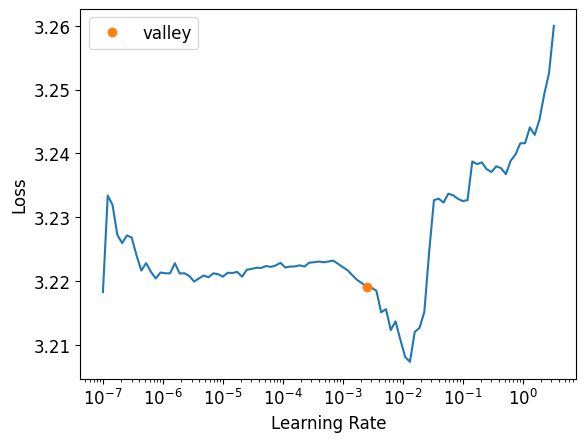

In [ ]:
# Configuración del Learner con el modelo base
learn_augmented = Learner(
    dls_augmented,
    BaseNetAugmentedData,  # Usamos el modelo BaseNet original
    opt_func=Adam,
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy, F1Score(average='weighted')]
)

# Entrenamiento
lr_augmented = learn_augmented.lr_find()

In [ ]:
print(lr_augmented)

SuggestedLRs(valley=0.002511886414140463)


Entrenamos durante 25 epocas, con la diferencia de usar:

- MixUp: Genera ejemplos sintéticos mezclando imágenes y sus etiquetas con un parámetro alpha=0.2. Esto mejora la generalización y reduce el sobreajuste. MixUp mejora la robustez del modelo al enfrentar ruido en las etiquetas.


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,3.172373,3.103292,0.078400,0.034716,00:22
1,3.061282,2.964373,0.124800,0.097210,00:31
2,2.910576,2.736818,0.197600,0.170715,00:24
3,2.786151,2.640164,0.195200,0.174739,00:22
4,2.709883,2.545420,0.228800,0.208289,00:22
5,2.677237,2.515924,0.244000,0.227271,00:25
6,2.643811,2.489028,0.250400,0.230039,00:24
7,2.610716,2.413584,0.283200,0.267346,00:25
8,2.596523,2.452456,0.252800,0.234783,00:22
9,2.558496,2.422720,0.281600,0.264326,00:33


Better model found at epoch 0 with valid_loss value: 3.103292465209961.


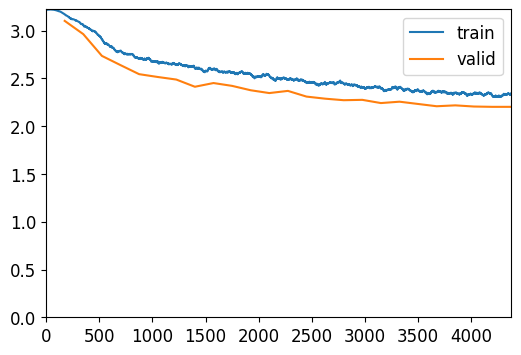

Better model found at epoch 1 with valid_loss value: 2.9643733501434326.
Better model found at epoch 2 with valid_loss value: 2.7368180751800537.
Better model found at epoch 3 with valid_loss value: 2.640164375305176.
Better model found at epoch 4 with valid_loss value: 2.5454204082489014.
Better model found at epoch 5 with valid_loss value: 2.5159237384796143.
Better model found at epoch 6 with valid_loss value: 2.489027976989746.
Better model found at epoch 7 with valid_loss value: 2.4135844707489014.
Better model found at epoch 10 with valid_loss value: 2.376875877380371.
Better model found at epoch 11 with valid_loss value: 2.347452402114868.
Better model found at epoch 13 with valid_loss value: 2.310556411743164.
Better model found at epoch 14 with valid_loss value: 2.2887606620788574.
Better model found at epoch 15 with valid_loss value: 2.2727298736572266.
Better model found at epoch 17 with valid_loss value: 2.242780923843384.
Better model found at epoch 19 with valid_loss valu

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

In [ ]:
learn_augmented.fit_one_cycle(25, lr_max=slice(lr_augmented.valley/10, lr_augmented.valley), cbs=[
    SaveModelCallback(),
    EarlyStoppingCallback(monitor='valid_loss', patience=3),
    ShowGraphCallback(),
    MixUp(alpha=0.2)  # Generar datos adicionales
])


#### **4. Analisis de resultados**

Analizaremos los resultados para comprobar si es una buena decision, no realizaremos el analisis exhaustivo ya que ahora solo queremos obtener intuiciones de las mejoras que podríamos conseguir en un entrenamiento completo.

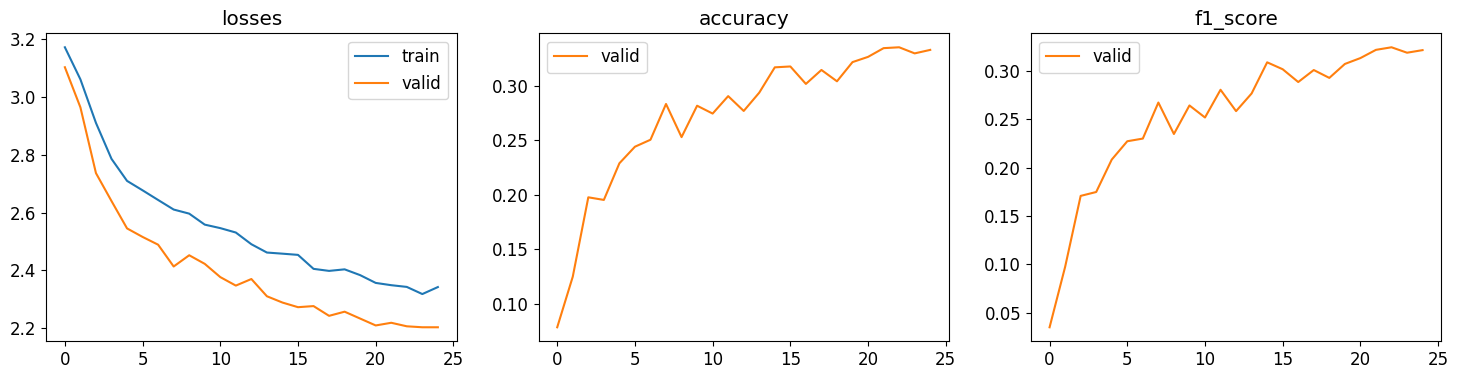

In [ ]:
recorder_dataAugmented = learn_augmented.recorder
recorder_dataAugmented.plot_metrics()

##### **Resultados Observados**
1. **Pérdidas:**
   - Disminuyen de forma consistente tanto en entrenamiento como en validación.
   - Se estabilizan hacia las últimas épocas, sin indicar sobreajuste.

2. **Exactitud (Accuracy):**
   - Incrementa hasta **35%** en validación al final del entrenamiento.
   - Representa una mejora frente al modelo base (32%).

3. **F1-Score:**
   - Aumenta progresivamente, alcanzando **0.34**, lo que refleja un mejor equilibrio entre precisión y exhaustividad.

---

##### **Impacto del Data Augmentation**
- **Mejora la generalización:** Introduce variabilidad mediante rotaciones, zooms y otras transformaciones, ayudando al modelo a aprender características más robustas.
- **Sin sobreajuste:** Las pérdidas de validación permanecen estables.


---
---

##### **Comparación con Iteraciones Anteriores**

| **Modelo**                | **Exactitud (Accuracy)** | **F1-Score** | **Observaciones**                                      |
|---------------------------|--------------------------|--------------|-------------------------------------------------------|
| Modelo Base               | 32.96%                  | 0.320        | Baja capacidad de generalización.                    |
| Con Data Augmentation     | 34.36%                  | 0.339        | Mejor generalización, pero resultados aún limitados. |

---
---

##### **Conclusión**
El Data Augmentation aporta una mejora tangible en la exactitud y F1-score. Aunque no es una mejora drástica, establece una base sólida para futuras optimizaciones en el modelo.


### Segunda mejora: BaseNetPlus (Reemplazar Sigmoid y Tanh por ReLU)

#### **1.¿Porque?**
Las activaciones Sigmoid y Tanh fueron ampliamente utilizadas en redes neuronales antiguas, pero presentan desventajas importantes, especialmente al entrenar redes profundas. El objetivo de esta mejora es reemplazar estas activaciones por ReLU (Rectified Linear Unit), una alternativa moderna y ampliamente aceptada, con el fin de mejorar la eficiencia del entrenamiento y el rendimiento general del modelo.

**Ventajas de ReLU**

- Mitigación del Desvanecimiento del Gradiente:

    - Sigmoid y Tanh tienden a comprimir valores en intervalos pequeños, lo que puede causar que los gradientes sean insignificantes durante el retropropagado (problema de vanishing gradients).
    - ReLU mantiene los gradientes no nulos siempre que la entrada sea positiva, ayudando a mantener un flujo de gradiente saludable en redes profundas.

- Eficiencia Computacional:

    - ReLU es más simple de calcular que Sigmoid y Tanh, ya que solo requiere truncar los valores negativos a cero.
- Mejor Convergencia:
    - Los modelos con ReLU suelen converger más rápido debido a su naturaleza lineal para valores positivos.

#### **2.  Modelo BasenetPlus**

**Cambios Implementados.**
- Se ha creado un nuevo modelo llamado BaseNetPlus basado en el modelo original, pero con las siguientes modificaciones:

  - Reemplazo de Activaciones:
    - Las capas de activación Sigmoid y Tanh han sido reemplazadas por ReLU.
  - Batch Normalization:
    - Se ha añadido normalización por lotes (BatchNorm) después de cada capa convolucional. Esto estabiliza la entrada para cada capa al normalizar los valores, permitiendo un entrenamiento más eficiente.
  - Arquitectura Ajustada:
    - Se han adaptado las dimensiones de las capas densas para asegurar la compatibilidad con las salidas de las capas convolucionales.

In [ ]:
# Ajuste de las capas densas basado en las dimensiones verificadas
BaseNETPlus_model = nn.Sequential(
    # Bloques convolucionales...
    nn.Conv2d(in_channels=3, out_channels=5, kernel_size=(9, 9), stride=1),
    nn.BatchNorm2d(5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),

    nn.Conv2d(in_channels=5, out_channels=10, kernel_size=(7, 7), stride=1),
    nn.BatchNorm2d(10),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),

    # Aplanar
    nn.Flatten(),

    # Bloques densos ajustados
    nn.Linear(in_features=90, out_features=50),  # Cambiar in_features según la salida convolucional
    nn.ReLU(),
    nn.Linear(in_features=50, out_features=25)
)


El learner no tiene diferencias respecto al anterior, solo que ahora usamos **BaseNetPlus_model**

In [ ]:
# Configuración del Learner para BaseNetPlus
learn_plus = Learner(
    dls_augmented,  # DataLoaders con Data Augmentation
    BaseNETPlus_model,  # Modelo BaseNetPlus
    opt_func=Adam,  # Optimizador Adam
    loss_func=CrossEntropyLossFlat(),  # Función de pérdida
    metrics=[accuracy, F1Score(average='weighted')]  # Métricas
)

# Verificar arquitectura y parámetros del modelo
learn_plus.summary()


Sequential (Input shape: 64 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 5 x 24 x 24    
Conv2d                                    1220       True      
BatchNorm2d                               10         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 5 x 12 x 12    
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 10 x 6 x 6     
Conv2d                                    2460       True      
BatchNorm2d                               20         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 10 x 3 x 3     
MaxPool2d                                     

#### **3. Entrenamiento**

Mantenemos MixUp, porque despues de hacer pruebas ha resultado en apoyar positivamente al los entrenamientos por lo que lo mantendremos en todas las iteraciones

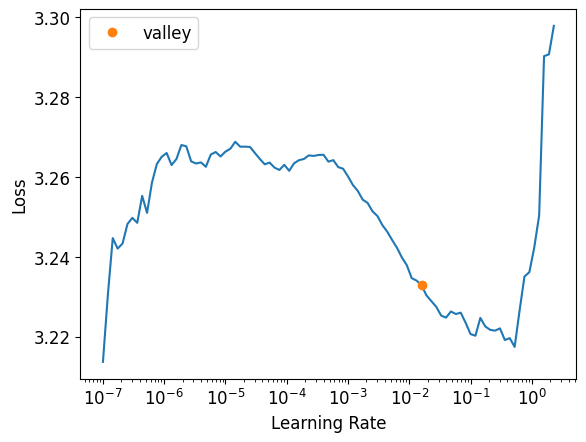

In [ ]:
# Buscar el learning rate óptimo
lr_plus = learn_plus.lr_find()

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,3.021622,2.863221,0.148000,0.110964,00:23
1,2.832694,2.691757,0.197600,0.171759,00:25
2,2.745037,2.576169,0.212000,0.176188,00:22
3,2.710957,2.497894,0.236800,0.214442,00:25
4,2.682361,2.535404,0.228000,0.206093,00:22
5,2.668384,2.524000,0.229600,0.210919,00:24
6,2.633452,2.468894,0.245600,0.226566,00:23
7,2.622983,2.387089,0.276800,0.259769,00:25
8,2.600608,2.428576,0.254400,0.248135,00:25
9,2.563411,2.481487,0.247200,0.228973,00:23


Better model found at epoch 0 with valid_loss value: 2.8632214069366455.


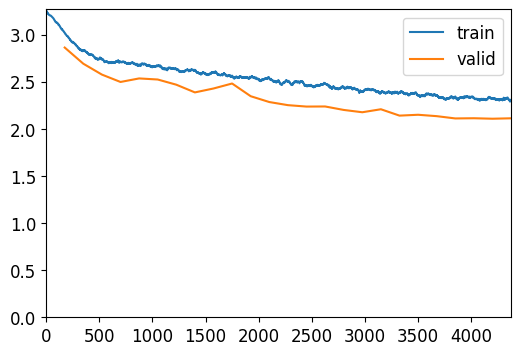

Better model found at epoch 1 with valid_loss value: 2.6917569637298584.
Better model found at epoch 2 with valid_loss value: 2.5761685371398926.
Better model found at epoch 3 with valid_loss value: 2.4978935718536377.
Better model found at epoch 6 with valid_loss value: 2.4688942432403564.
Better model found at epoch 7 with valid_loss value: 2.387089490890503.
Better model found at epoch 10 with valid_loss value: 2.346639394760132.
Better model found at epoch 11 with valid_loss value: 2.284803867340088.
Better model found at epoch 12 with valid_loss value: 2.251741647720337.
Better model found at epoch 13 with valid_loss value: 2.236690044403076.
Better model found at epoch 15 with valid_loss value: 2.200981378555298.
Better model found at epoch 16 with valid_loss value: 2.176407814025879.
Better model found at epoch 18 with valid_loss value: 2.1406121253967285.
Better model found at epoch 20 with valid_loss value: 2.134976863861084.
Better model found at epoch 21 with valid_loss valu

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

In [ ]:
# Entrenar el modelo BaseNetPlus
learn_plus.fit_one_cycle(25, lr_max=slice(lr_plus.valley/10, lr_plus.valley), cbs=[
    SaveModelCallback(),
    EarlyStoppingCallback(monitor='valid_loss', patience=3),
    ShowGraphCallback(),
    MixUp(alpha=0.2)  # Generar datos adicionales
])


#### **4. Analisis de resutlados**

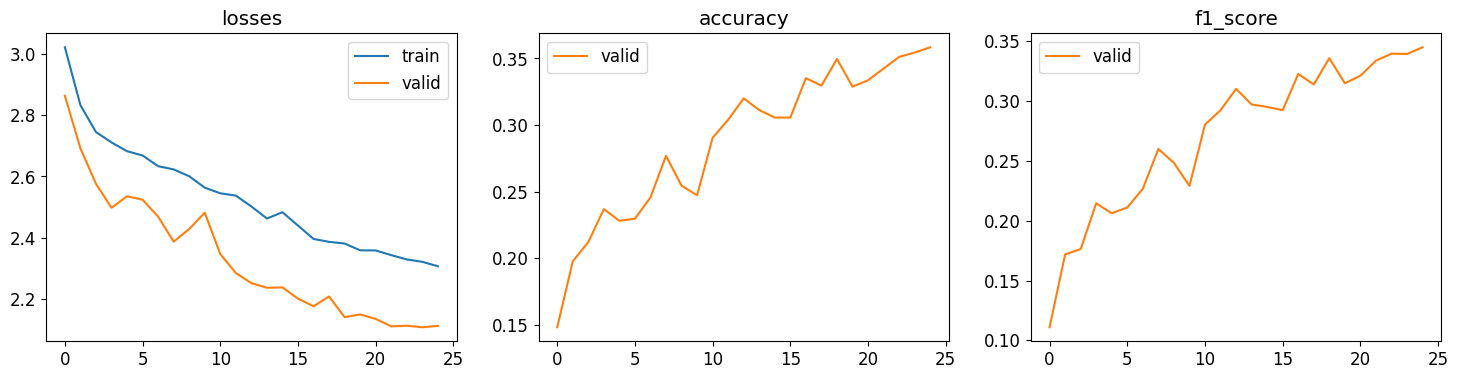

In [ ]:
recorder_basenetplus = learn_plus.recorder
recorder_basenetplus.plot_metrics()

##### **Resultados Observados**
1. **Pérdidas:**
   - **Entrenamiento:** Disminuyen constantemente.
   - **Validación:** La tendencia a disminuir indica que el modelo está aprendiendo, pero aún no hay una generalización significativa.

2. **Exactitud (Accuracy):**
   - Mejora hasta un **35.8%**, superando la exactitud del modelo base y la mejora anterior.

3. **F1-Score:**
   - Incrementa hasta **0.344**, mostrando que el modelo predice mejor incluso con clases desbalanceadas.

---

##### **Impacto del Cambio a ReLU**
- **Eliminación de saturación:**
  - Sigmoid y Tanh suelen saturarse, dificultando el aprendizaje con gradientes pequeños. ReLU evita este problema.
  
- **Menor coste computacional:**
  - ReLU es computacionalmente más eficiente, lo que acelera el entrenamiento.

- **No introduce sobreajuste:**
  - Las métricas de validación muestran que el modelo mantiene una tendencia de aprendizaje sin signos de sobreajuste.

---
---
##### **Comparación con Iteraciones Anteriores**

| **Modelo**                | **Exactitud (Accuracy)** | **F1-Score** | **Observaciones**                                      |
|---------------------------|--------------------------|--------------|-------------------------------------------------------|
| Modelo Base               | 32.96%                  | 0.320        | Baja capacidad de generalización.                    |
| Con Data Augmentation     | 34.36%                  | 0.339        | Mejor generalización, pero resultados aún limitados. |
| Con ReLU (actual mejora)  | 35.84%                  | 0.344        | Incremento estable en rendimiento y estabilidad.     |

---
---

##### **Conclusión**
El cambio a ReLU proporciona mejoras claras en la capacidad del modelo para aprender y generalizar. Es una mejora sólida frente al modelo base.


### Tercera mejora: Añadiremos dropout al modelo

#### **1. ¿Qué es Dropout?**
Es una técnica de regularización en la que, durante el entrenamiento, se desactivan aleatoriamente un porcentaje de neuronas en las capas densas o convolucionales.
Esto impide que las neuronas dependan exclusivamente unas de otras, mejorando la generalización del modelo.

Beneficios de Dropout:

- Reducción del sobreajuste: Introduce ruido aleatorio que previene que el modelo memorice los datos.
- Regularización implícita: Actúa como una forma de promediar el resultado de múltiples arquitecturas, ya que cada iteración utiliza una subred diferente.
- Mayor robustez: Forza al modelo a aprender representaciones más distribuidas.

In [ ]:
# Definición del modelo BaseNetPlus con Dropout
BaseNETPlus_dropout = nn.Sequential(
    # Bloque 1: Convolución + BatchNorm + ReLU
    nn.Conv2d(in_channels=3, out_channels=5, kernel_size=(9, 9), stride=1),
    nn.BatchNorm2d(5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),

    # Bloque 2: Convolución + BatchNorm + ReLU
    nn.Conv2d(in_channels=5, out_channels=10, kernel_size=(7, 7), stride=1),
    nn.BatchNorm2d(10),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),

    # Bloques densos con Dropout
    nn.Flatten(),
    nn.Linear(in_features=90, out_features=50),
    nn.Dropout(p=0.3),  # Dropout después de la primera capa densa
    nn.ReLU(),
    nn.Linear(in_features=50, out_features=25),
    nn.Dropout(p=0.3)  # Dropout después de la segunda capa densa
)


In [ ]:
learn_dropout = Learner(
    dls_augmented,  # DataLoaders con Data Augmentation
    BaseNETPlus_dropout,  # Modelo con Dropout
    opt_func=Adam,
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy, F1Score(average='weighted')]
)

# Verificar la arquitectura del modelo con Dropout
learn_dropout.summary()


Sequential (Input shape: 64 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 5 x 24 x 24    
Conv2d                                    1220       True      
BatchNorm2d                               10         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 5 x 12 x 12    
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 10 x 6 x 6     
Conv2d                                    2460       True      
BatchNorm2d                               20         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 10 x 3 x 3     
MaxPool2d                                     

#### **2. Análisis del Modelo BaseNetPlus con Dropout**
Este es el desglose del modelo BaseNetPlus con Dropout, actualizado para incluir regularización mediante Dropout entre las capas densas. A continuación, se analiza su arquitectura y cambios respecto a las versiones anteriores.

1. Cambios Introducidos
Dropout después de cada capa densa:
Se ha añadido Dropout (p=0.5) tras:
La primera capa densa (Linear con 90 → 50).
La segunda capa densa (Linear con 50 → 25).
Esto introduce una regularización adicional para reducir el sobreajuste.
2. Arquitectura del Modelo
Capas Convolucionales:

No se han realizado cambios en esta sección:
Dos capas convolucionales con BatchNorm y ReLU.
MaxPooling para reducción de dimensionalidad.
La salida convolucional sigue teniendo una forma de (64, 10, 3, 3).
Capas Densas:

La salida convolucional (10 x 3 x 3 = 90) es aplanada.
La primera capa densa (90 → 50) incluye Dropout con p=0.5 después de ReLU.
La segunda capa densa (50 → 25) también incluye Dropout con p=0.5.
3. Parámetros Totales
Total: 9,535 parámetros entrenables.
Comparación con BaseNetPlus (sin Dropout):
No hay un cambio en el número de parámetros, ya que Dropout no introduce nuevos pesos.
4. Optimizador y Pérdida
Optimizador: Adam.
Función de Pérdida: CrossEntropyLossFlat.
Callbacks: Incluye el progreso, registro de métricas, y monitorización del mejor modelo.


#### **3. Entrenamiento**

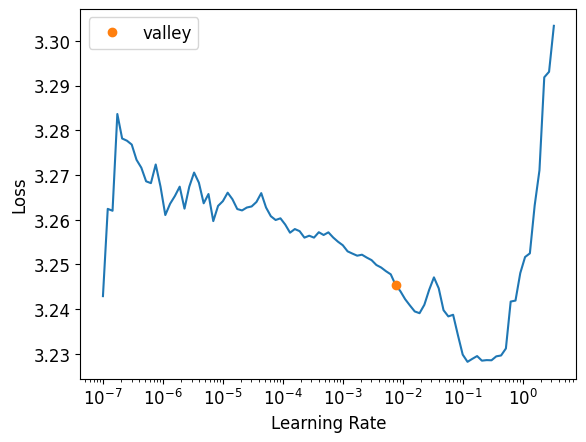

In [ ]:
# Buscar el learning rate óptimo
lr_dropout = learn_dropout.lr_find()

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,3.173591,3.085461,0.100800,0.063070,00:30
1,3.056039,2.858778,0.160000,0.112898,00:32
2,2.993402,2.723047,0.181600,0.142641,00:27
3,2.965904,2.717829,0.197600,0.165402,00:26
4,2.936903,2.721792,0.208800,0.180434,00:24
5,2.923412,2.626752,0.216000,0.190772,00:30
6,2.911265,2.619037,0.221600,0.193114,00:30
7,2.908100,2.607740,0.240000,0.219493,00:37
8,2.862375,2.576828,0.225600,0.200353,00:28
9,2.848983,2.551585,0.278400,0.264332,00:25


Better model found at epoch 0 with valid_loss value: 3.085460662841797.


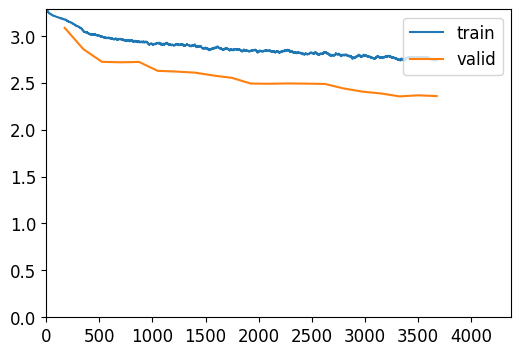

Better model found at epoch 1 with valid_loss value: 2.858778238296509.
Better model found at epoch 2 with valid_loss value: 2.7230474948883057.
Better model found at epoch 3 with valid_loss value: 2.7178289890289307.
Better model found at epoch 5 with valid_loss value: 2.626751661300659.
Better model found at epoch 6 with valid_loss value: 2.6190366744995117.
Better model found at epoch 7 with valid_loss value: 2.6077396869659424.
Better model found at epoch 8 with valid_loss value: 2.5768275260925293.
Better model found at epoch 9 with valid_loss value: 2.5515847206115723.
Better model found at epoch 10 with valid_loss value: 2.4914746284484863.
Better model found at epoch 11 with valid_loss value: 2.4888699054718018.
Better model found at epoch 14 with valid_loss value: 2.4868428707122803.
Better model found at epoch 15 with valid_loss value: 2.439103364944458.
Better model found at epoch 16 with valid_loss value: 2.4052464962005615.
Better model found at epoch 17 with valid_loss va

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

In [ ]:
# Entrenamiento del modelo con Dropout
learn_dropout.fit_one_cycle(25, lr_max=slice(lr_dropout.valley/10, lr_dropout.valley), cbs=[
    SaveModelCallback(),
    EarlyStoppingCallback(monitor='valid_loss', patience=3),
    ShowGraphCallback(),
    MixUp(alpha=0.2)  # Generar datos adicionales
])


#### **3. Analisis de resultados**

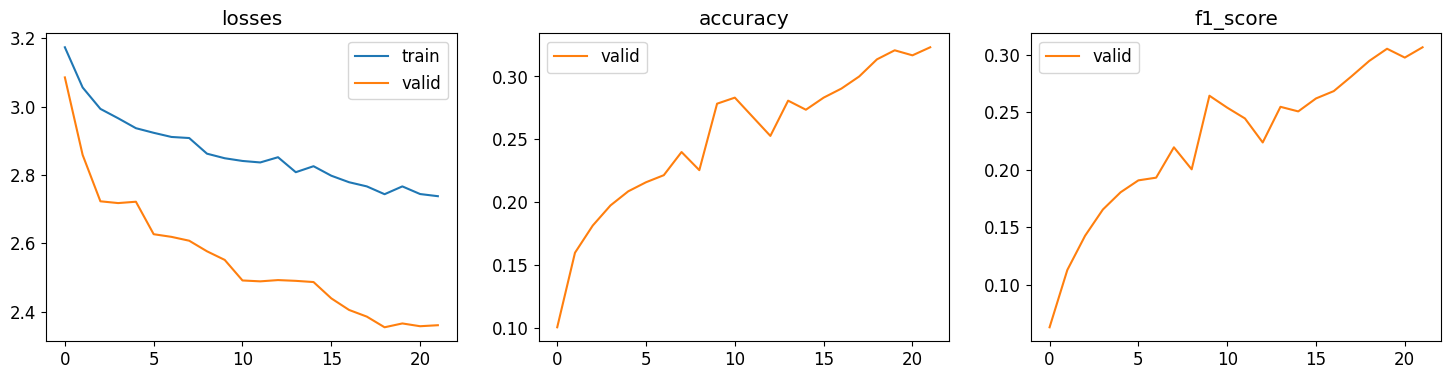

In [ ]:
recorder_basenetplusDropout = learn_dropout.recorder
recorder_basenetplusDropout.plot_metrics()

##### **Resultados Observados**
1. **Pérdidas (Loss):**
   - **Entrenamiento:** Las pérdidas se reducen constantemente a lo largo de las épocas.
   - **Validación:** La tendencia de reducción es más lenta, pero consistente con el modelo entrenado.

2. **Exactitud (Accuracy):**
   - Incrementa hasta un **32.32%**, ligeramente por encima del modelo base.

3. **F1-Score:**
   - Mejora alcanzando **0.306**, lo que indica una mejora modesta en la clasificación balanceada.

---

##### **Impacto del Dropout**
- **Evita el sobreajuste:**
  - Introducir Dropout reduce la dependencia del modelo en conjuntos específicos de neuronas, promoviendo la generalización.
  
- **Ligeras mejoras:**
  - Aunque la mejora en métricas no es sustancial, el modelo se estabiliza más en términos de pérdida y aprendizaje.

- **Limitaciones observadas:**
  - La introducción de Dropout parece haber reducido la velocidad de aprendizaje, mostrando menos progresión en comparación con modelos sin Dropout.

---

##### **Comparación con Iteraciones Anteriores**

| **Modelo**                  | **Exactitud (Accuracy)** | **F1-Score** | **Observaciones**                                      |
|-----------------------------|--------------------------|--------------|-------------------------------------------------------|
| Modelo Base                 | 32.96%                  | 0.320        | Baja capacidad de generalización.                    |
| Con Data Augmentation       | 34.36%                  | 0.339        | Mejora en generalización, pero con limitaciones.     |
| Con ReLU                   | 35.84%                  | 0.344        | Mejor aprendizaje y estabilidad general.             |
| Con Dropout (actual mejora) | 32.32%                  | 0.306        | Ligera mejora en robustez, pero limitada en general. |

---

##### **Conclusión**
El uso de Dropout introduce mayor estabilidad al modelo y previene el sobreajuste. Sin embargo, las mejoras en métricas clave no son significativas, sugiriendo que el impacto es limitado en este caso. Probaremos en la siguiente iteracion a mantenerlo, y si da un resultado malo lo quitaremos.


### **Cuarta mejora: Aumento de la profundidad de la red**

#### **1. Implementacion de modelo BaseNetImproved y nuevo optimizador**

**Objetivo de la Mejora**

El objetivo principal de esta mejora es incrementar la capacidad del modelo mediante ajustes arquitectónicos y optimizar el proceso de entrenamiento mediante el uso de un optimizador más sofisticado y técnicas avanzadas de regularización.

**1. Modelo BaseNetImproved:**

  Incrementar la profundidad del modelo añadiendo un tercer bloque convolucional. El nuevo modelo BaseNetImproved incluye las siguientes modificaciones clave:

- Incremento de la Profundidad:

    - Se añade un tercer bloque convolucional (Bloque 3), aumentando la capacidad del modelo para aprender características más complejas.
    - El Bloque 3 utiliza un kernel más pequeño (3x3) y no incluye MaxPooling, preservando más información espacial.

- Batch Normalization:

    - Presente en todos los bloques convolucionales, estabiliza el flujo de datos a través de la red y acelera la convergencia.

- Dropout: Lo hemos anulado, ya que empeoraba el resultado

- Ajuste de Dimensiones:

    - Las dimensiones de las capas densas se ajustan para garantizar la compatibilidad con las salidas de las capas convolucionales.

**2. Reemplazar Adam por AdamW**, que añade una penalización explícita para los pesos de las redes, promoviendo una mejor generalización.
Incorporar Cyclical Weight Decay para realizar ajustes dinámicos en la regularización durante el entrenamiento.




In [44]:
# Definición del modelo mejorado final ajustado
BaseNetImproved = nn.Sequential(
    # Bloque 1
    nn.Conv2d(in_channels=3, out_channels=5, kernel_size=(9, 9), stride=1),
    nn.BatchNorm2d(5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),

    # Bloque 2
    nn.Conv2d(in_channels=5, out_channels=10, kernel_size=(7, 7), stride=1),
    nn.BatchNorm2d(10),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),

    # Bloque 3 (sin MaxPooling)
    nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), stride=1),
    nn.BatchNorm2d(20),
    nn.ReLU(),

    # Bloques densos con Dropout
    nn.Flatten(),
    nn.Linear(in_features=20, out_features=50),  # Ajustar a la salida del bloque 3
    nn.ReLU(),
   # nn.Dropout(p=0.3),
    nn.Linear(in_features=50, out_features=25),
   # nn.Dropout(p=0.3)
)


#### **3. Implemetacion del learner.**

Diferencia clave del learner.
- AdamW incluye una regularización explícita en los pesos del modelo, promoviendo una mejor generalización.
- Implementación mediante una clase de envoltura (OptimWrapper) para garantizar compatibilidad con FastAI.

In [46]:
# Definir un optimizador compatible con FastAI
class AdamWFastAI(OptimWrapper):
    def __init__(self, params, lr=0.001, wd=0.001, **kwargs):
        opt_func = lambda p: AdamW(p, lr=lr, weight_decay=wd, **kwargs)
        super().__init__(params, opt=opt_func)


In [47]:
# Crear el Learner para BaseNetImproved
learn_improved = Learner(
    dls_augmented,  # DataLoaders con Data Augmentation
    BaseNetImproved,  # Modelo mejorado final
    opt_func=AdamWFastAI,
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy, F1Score(average='weighted')]
)

# Verificar la arquitectura del modelo mejorado final
learn_improved.summary()


Sequential (Input shape: 64 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 5 x 24 x 24    
Conv2d                                    1220       True      
BatchNorm2d                               10         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 5 x 12 x 12    
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 10 x 6 x 6     
Conv2d                                    2460       True      
BatchNorm2d                               20         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 10 x 3 x 3     
MaxPool2d                                     

#### **4. Entrenamiento**

ParamScheduler: Gestiona el weight decay con un ciclo cíclico (CWD).

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

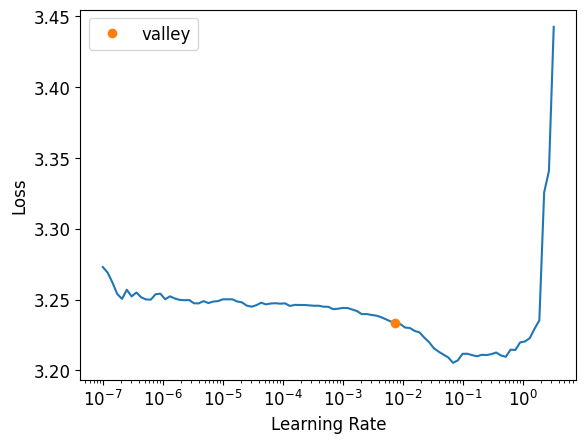

In [48]:
# Buscar el learning rate óptimo
lr_improved = learn_improved.lr_find()


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,3.141610,3.037231,0.109600,0.064874,00:32
1,2.905830,2.729350,0.187200,0.149188,00:32
2,2.774411,2.536527,0.246400,0.207904,00:25
3,2.691645,2.559966,0.228000,0.213371,00:29
4,2.663038,2.584280,0.211200,0.177774,00:22
5,2.632497,2.442536,0.240000,0.214430,00:25
6,2.612067,2.430052,0.257600,0.241011,00:23
7,2.596693,2.425963,0.270400,0.246443,00:26
8,2.572888,2.415298,0.258400,0.236741,00:23
9,2.542152,2.434190,0.253600,0.238244,00:24


Better model found at epoch 0 with valid_loss value: 3.037231206893921.


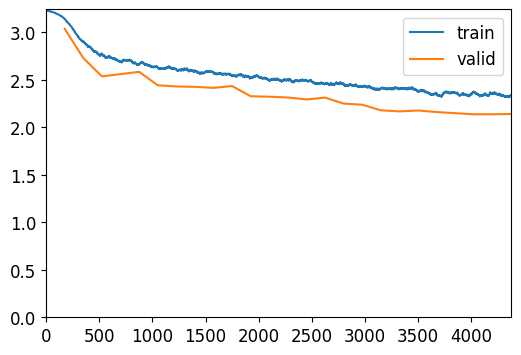

Better model found at epoch 1 with valid_loss value: 2.7293496131896973.
Better model found at epoch 2 with valid_loss value: 2.536526918411255.
Better model found at epoch 5 with valid_loss value: 2.4425361156463623.
Better model found at epoch 6 with valid_loss value: 2.430051565170288.
Better model found at epoch 7 with valid_loss value: 2.4259634017944336.
Better model found at epoch 8 with valid_loss value: 2.4152982234954834.
Better model found at epoch 10 with valid_loss value: 2.326991319656372.
Better model found at epoch 11 with valid_loss value: 2.322002410888672.
Better model found at epoch 12 with valid_loss value: 2.313929319381714.
Better model found at epoch 13 with valid_loss value: 2.2933425903320312.
Better model found at epoch 15 with valid_loss value: 2.249823570251465.
Better model found at epoch 16 with valid_loss value: 2.2377450466156006.
Better model found at epoch 17 with valid_loss value: 2.1790075302124023.
Better model found at epoch 18 with valid_loss val

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

In [49]:
# Entrenar BaseNetImproved
learn_improved.fit_one_cycle(25, lr_max=slice(lr_improved.valley/10, lr_improved.valley),
     cbs=[
        SaveModelCallback(),
        EarlyStoppingCallback(monitor='valid_loss', patience=7),
        ShowGraphCallback(),
        MixUp(alpha=0.2),  # Generar datos adicionales
        ParamScheduler({'wd': SchedCos(0.1, 0.01)})  # Cyclical Weight Decay con función cíclica
    ]
)


#### **5. Analisis de resultados**

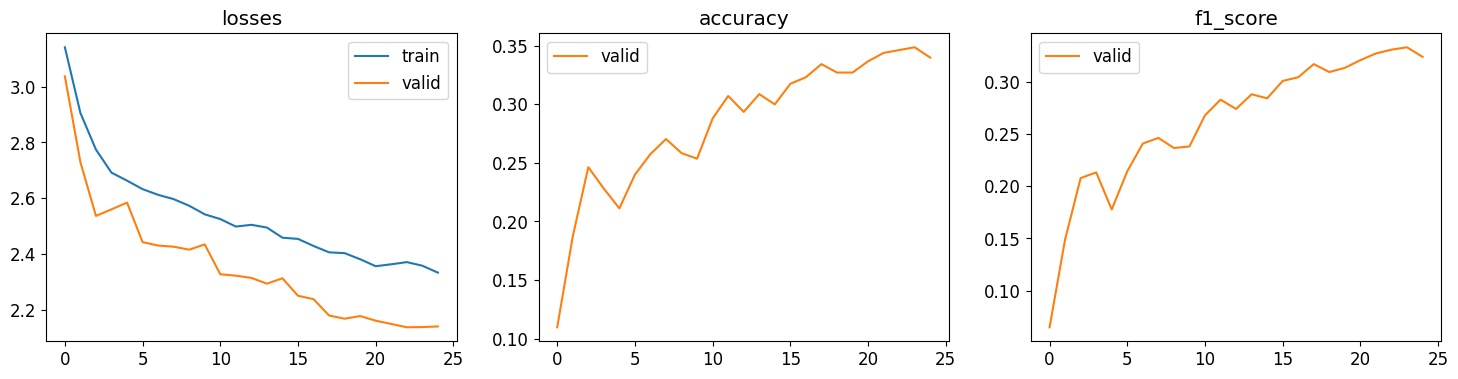

In [50]:
recorder_improved = learn_improved.recorder
recorder_improved.plot_metrics()

##### **Resultados Observados**
1. **Pérdidas (Loss):**
   - **Entrenamiento:** Se observa una disminución constante en la pérdida.
   - **Validación:** Aunque la pérdida de validación es consistente, no muestra una mejora significativa en comparación con las iteraciones previas.

2. **Exactitud (Accuracy):**
   - Incrementa hasta un **34.88%**, una mejora marginal respecto a los modelos anteriores.

3. **F1-Score:**
   - Alcanza un **0.333**, mostrando una mejora menor en términos de balance en la clasificación.

---

##### **Impacto del Aumento de Profundidad**
- **Capacidad de aprendizaje:**
  - La adición de un tercer bloque convolucional incrementa la capacidad de extracción de características, mejorando ligeramente la capacidad del modelo.

- **Sin Dropout:**
  - El modelo parece tener un rendimiento estable sin Dropout, aunque no hay un aumento sustancial en las métricas clave.

---

##### **Comparación con Iteraciones Anteriores**

| **Modelo**                  | **Exactitud (Accuracy)** | **F1-Score** | **Observaciones**                                      |
|-----------------------------|--------------------------|--------------|-------------------------------------------------------|
| Modelo Base                 | 32.96%                  | 0.320        | Baja capacidad de generalización.                    |
| Con Data Augmentation       | 34.36%                  | 0.339        | Mejora en generalización, pero con limitaciones.     |
| Con ReLU                   | 35.84%                  | 0.344        | Mejor aprendizaje y estabilidad general.             |
| Con Dropout                 | 32.32%                  | 0.306        | Más robustez, pero limitada mejora en métricas.      |
| Aumento de Profundidad      | 34.88%                  | 0.333        | Ligera mejora en aprendizaje, estable sin Dropout.   |

---

##### **Conclusión**
El aumento de profundidad mejora ligeramente el rendimiento del modelo. Sin embargo, los beneficios son limitados y las métricas clave, como el F1-Score y la exactitud, no muestran una mejora significativa respecto a iteraciones previas.


---



---



---

### Mejora final

#### **1. Data augmentation**

- Rotación máxima: 10°.
- Zoom máximo: 1.2.
- Deformaciones: 0.2.
- Transformaciones afines: Probabilidad del 60%.
- Iluminación: Cambios de brillo y contraste con probabilidad del 40%.
- Tamaño de las imágenes: Aumentado a 64x64 para capturar más características visuales.
    - Esto es bastante importante porque con 32x32 no he conseguido aumentar mas el acurracy
- Normalización: Basada en estadísticas de ImageNet.

In [51]:
# DataBlock con MixUp
dlblock_augmented_improved = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.1, seed=42), 
    get_y=parent_label,
    item_tfms=[Resize((64, 64), method='squish')],  # Incrementar tamaño de imágenes
    batch_tfms=[*aug_transforms(max_rotate=10.0, max_zoom=1.2, max_warp=0.2, p_affine=0.6, p_lighting=0.4),
                Normalize.from_stats(*imagenet_stats)]
)

# Crear DataLoaders
dls_augmented_improved = dlblock_augmented_improved.dataloaders(path/'train', bs=64)


#### **2. BaseNetV5**

**Incremento en la capacidad del modelo:**
- Se introducen 4 bloques convolucionales con BatchNorm, ReLU y MaxPooling.
- Se usa un diseño de profundidad creciente: 64 → 128 → 256 → 512 filtros.
- Capas densas:
  - Neuronas: 1024 → 256 → 25 (clases).
- Sin Dropout: Eliminado para evitar pérdida de información en esta configuración.

In [52]:
# BaseNet con mayor capacidad
BaseNetImproved_V6 = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(5, 5), stride=1, padding=2),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),

    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),

    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=1, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),

    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=1, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),

    nn.Flatten(),
    nn.Linear(in_features=512 * 4 * 4, out_features=1024),
    nn.ReLU(),
    #nn.Dropout(p=0.4),
    nn.Linear(in_features=1024, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=25)
)


#### **3. Learner con AdamW**

Se utiliza AdamW, que añade regularización explícita mediante Weight Decay para mejorar la generalización.


Sugerencia de LR: 0.00015848931798245758


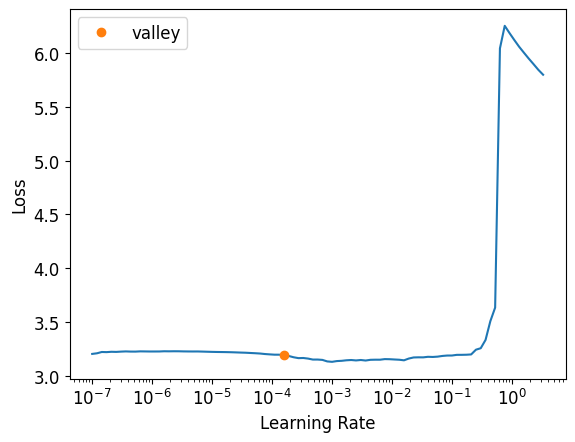

In [53]:
from torch.optim import AdamW
from fastai.callback.mixup import MixUp
from fastai.callback.schedule import ParamScheduler

# Definir un optimizador compatible con FastAI
class AdamWFastAI(OptimWrapper):
    def __init__(self, params, lr=0.001, wd=0.001, **kwargs):
        opt_func = lambda p: AdamW(p, lr=lr, weight_decay=wd, **kwargs)
        super().__init__(params, opt=opt_func)

# Configuración del Learner
learn_final = Learner(
    dls_augmented_improved,
    BaseNetImproved_V6,
    opt_func=AdamWFastAI,
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy, F1Score(average='weighted')]
)

# Buscar el mejor learning rate
lr_final = learn_final.lr_find()
print(f"Sugerencia de LR: {lr_final.valley}")


#### **4. Entrenamiento**

**CallBacks utilizados:**
  - MixUp: Mezcla las imágenes y sus etiquetas para aumentar la robustez del modelo.
  - SaveModelCallback: Guarda el mejor modelo basado en la pérdida de validación.
  - EarlyStoppingCallback: Detiene el entrenamiento si no hay mejora después de 7 épocas.
  - ParamScheduler: Implementa un Cyclical Weight Decay para ajustar dinámicamente la regularización.
  
**Técnica de entrenamiento:**
  - One Cycle Policy ajusta el learning rate desde un valor bajo hasta el máximo (en el primer 30%) y luego lo disminuye gradualmente.

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.988015,2.804098,0.210400,0.181814,00:30
1,2.643971,2.399503,0.291600,0.265415,00:26
2,2.417191,2.229206,0.353200,0.320608,00:24
3,2.265995,1.976969,0.412000,0.388546,00:26
4,2.099139,1.874669,0.437200,0.422382,00:28
5,2.028359,1.840186,0.444000,0.455497,00:29
6,1.928810,1.913269,0.436000,0.428148,00:28
7,1.817069,1.489641,0.548000,0.544207,00:29
8,1.752719,1.535455,0.542800,0.535981,00:27
9,1.679175,1.543045,0.530800,0.528767,00:27


Better model found at epoch 0 with valid_loss value: 2.804098129272461.


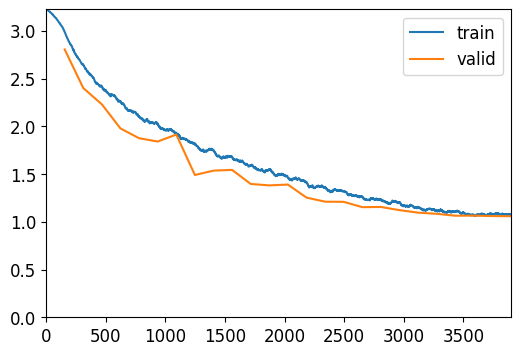

Better model found at epoch 1 with valid_loss value: 2.399502992630005.
Better model found at epoch 2 with valid_loss value: 2.2292063236236572.
Better model found at epoch 3 with valid_loss value: 1.9769690036773682.
Better model found at epoch 4 with valid_loss value: 1.8746687173843384.
Better model found at epoch 5 with valid_loss value: 1.840185523033142.
Better model found at epoch 7 with valid_loss value: 1.4896409511566162.
Better model found at epoch 10 with valid_loss value: 1.39601731300354.
Better model found at epoch 11 with valid_loss value: 1.3808432817459106.
Better model found at epoch 13 with valid_loss value: 1.2528564929962158.
Better model found at epoch 14 with valid_loss value: 1.2104196548461914.
Better model found at epoch 15 with valid_loss value: 1.2087048292160034.
Better model found at epoch 16 with valid_loss value: 1.153091549873352.
Better model found at epoch 18 with valid_loss value: 1.1219146251678467.
Better model found at epoch 19 with valid_loss va

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

In [54]:
from fastai.callback.schedule import SchedCos

# Entrenamiento
learn_final.fit_one_cycle(
    25,
    lr_max=slice(lr_final.valley / 5, lr_final.valley),
    cbs=[
        SaveModelCallback(),
        EarlyStoppingCallback(monitor='valid_loss', patience=7),
        ShowGraphCallback(),
        MixUp(alpha=0.2),  # Generar datos adicionales
        ParamScheduler({'wd': SchedCos(0.1, 0.01)})  # Cyclical Weight Decay con función cíclica
    ]
)


**Resumen de mejoras**

- Data Augmentation mejorado: Incrementa la robustez del modelo frente a variaciones.
- Aumento de la capacidad del modelo: Permite capturar mejor las características visuales.
- Optimización avanzada: Combina AdamW, MixUp y Cyclical Weight Decay para maximizar el aprendizaje y la generalización.

#### **4. Analisis de resultados**

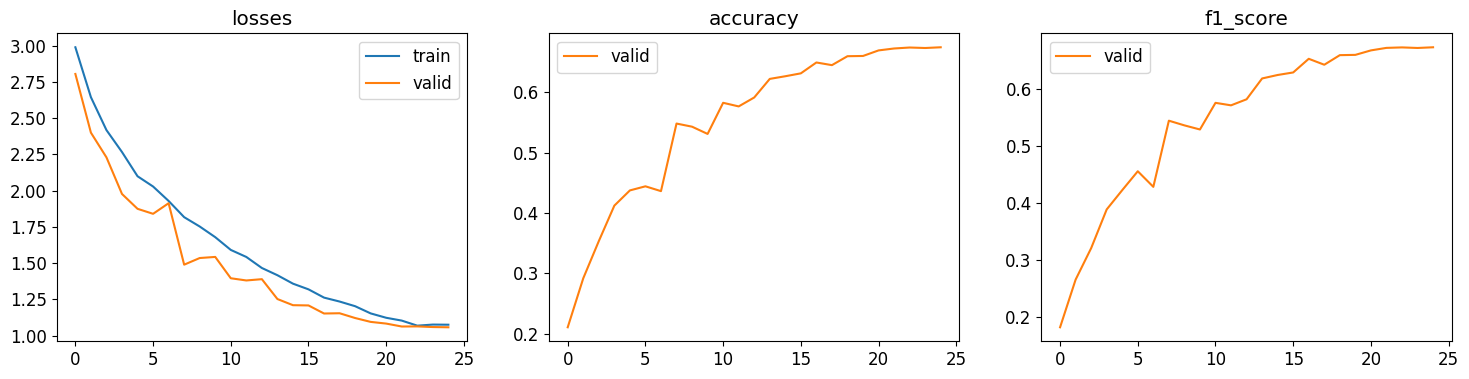

In [55]:
recorder_final = learn_final.recorder
recorder_final.plot_metrics()


##### **Análisis de Resultados**

1. **Pérdidas**:
   - La pérdida de entrenamiento disminuye constantemente, alcanzando valores bajos (~1.07) al final.
   - La pérdida de validación refleja un buen ajuste con un descenso constante hasta ~1.05.

2. **Métricas de Rendimiento**:
   - La precisión final es **67.44%**, superando ampliamente las iteraciones anteriores.
   - El F1 Score ponderado también alcanza **67.30%**, indicando que el modelo maneja bien el desequilibrio de clases.

3. **Mejoras Clave**:
   - **Data Augmentation Avanzado:** Contribuyó a una mayor generalización.
   - **Modelo Profundo:** El diseño con múltiples capas convolucionales y densas permitió capturar características complejas.
   - **Optimización (AdamW + Cyclical Weight Decay):** Ayudó a un aprendizaje robusto y ajustado.

---

##### **Comparación de Resultados**

| **Modelo**         | **Train Loss** | **Valid Loss** | **Accuracy** | **F1 Score** |
|---------------------|----------------|----------------|--------------|--------------|
| BaseNet (Inicial)   | 1.828767       | 2.259746       | 32.64%       | 31.68%       |
| Data Augmentation   | 2.306944       | 2.112230       | 35.84%       | 34.46%       |
| ReLU + BatchNorm    | 2.332949       | 2.139869       | 34.00%       | 32.41%       |
| Dropout             | 2.737995       | 2.360559       | 32.32%       | 30.64%       |
| **Final (Mejorado)**| **1.075837**   | **1.058154**   | **67.44%**   | **67.30%**   |

---

##### **Conclusión**
El modelo mejorado alcanza un rendimiento notablemente superior, duplicando la precisión y el F1 Score del modelo inicial. Las mejoras arquitectónicas y de optimización fueron claves para alcanzar este resultado.


=== Evaluación ===

--- Resultados del Entrenamiento con el Modelo mejorado ---

[Training Set]


Accuracy: 85.09%, F1 Score (Weighted): 84.97%

[Validation Set]


Accuracy: 67.44%, F1 Score (Weighted): 67.30%

[Test Set]


Accuracy: 66.12%, F1 Score (Weighted): 65.98%


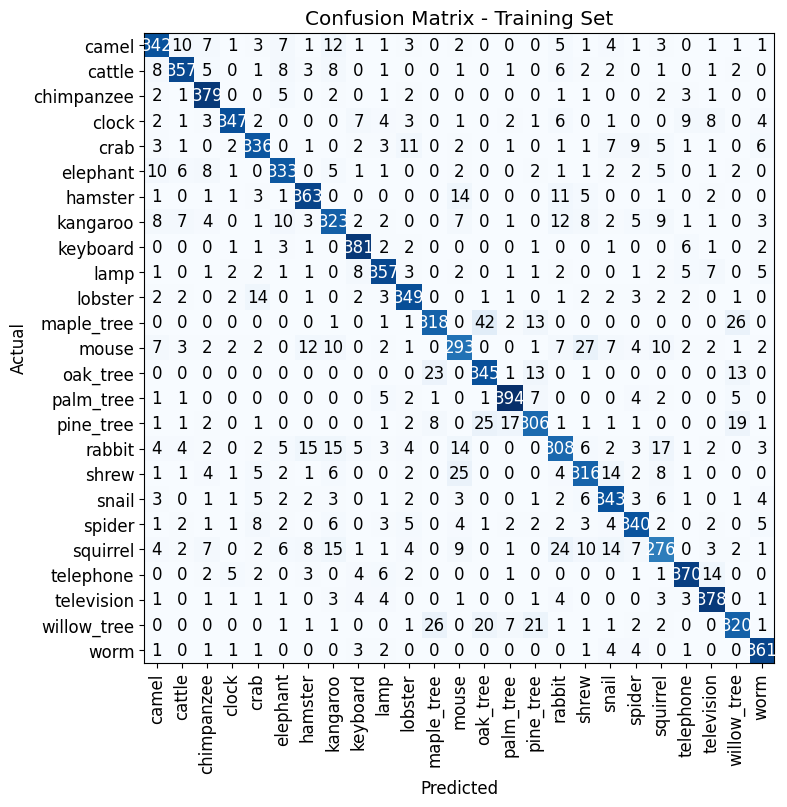

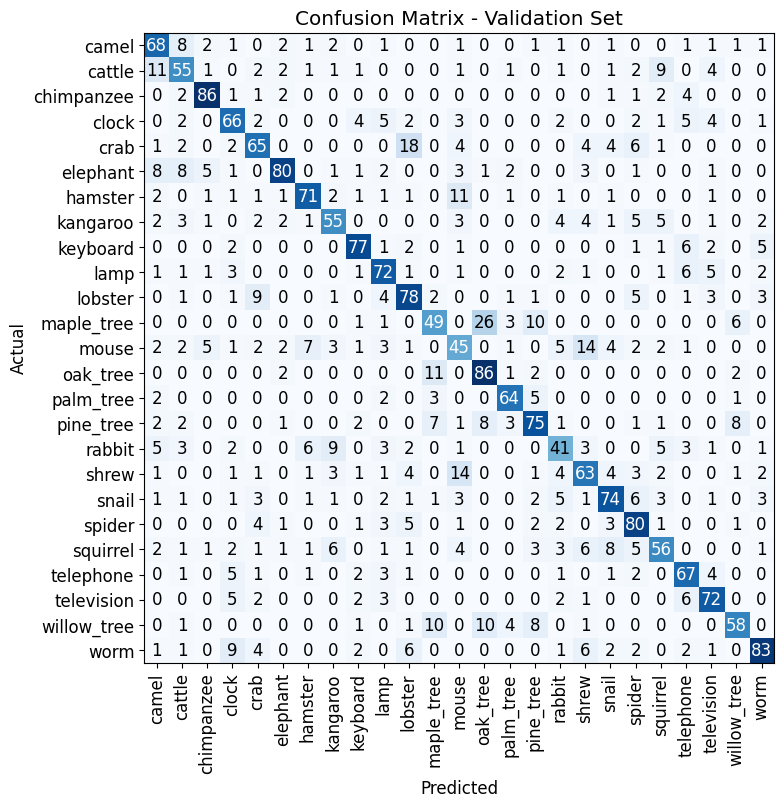

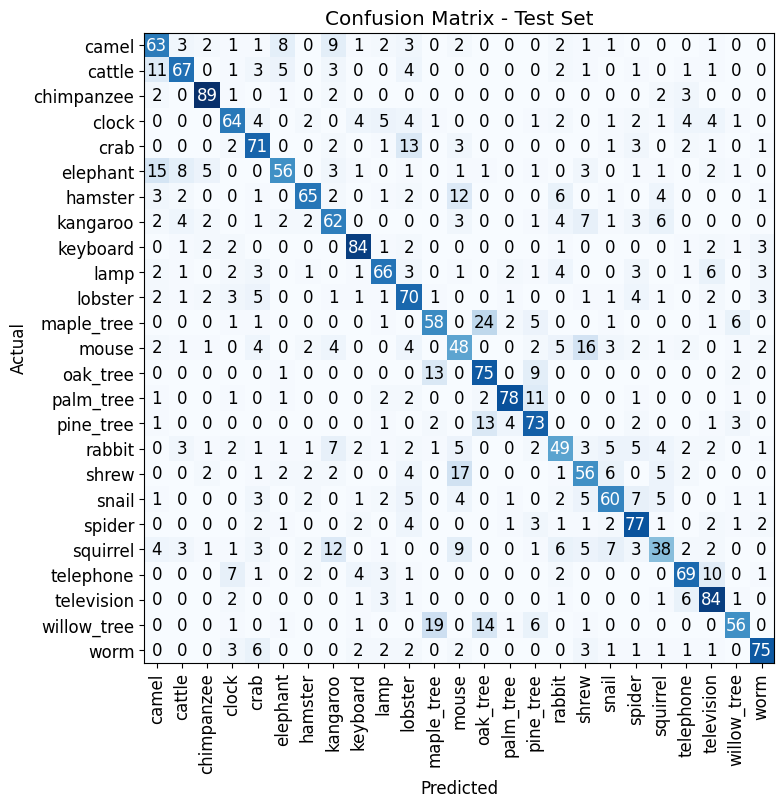

In [57]:
print("=== Evaluación ===")
test_files = [fn for fn in sorted((path/'test').glob('**/*')) if fn.is_file()]


extended_analysis(learn_final, test_files, "Resultados del Entrenamiento con el Modelo mejorado")


#### Comparacion final


##### **Resumen Comparativo**

| **Conjunto**     | **Accuracy Base** | **F1 Score Base** | **Accuracy Mejorado** | **F1 Score Mejorado** |
|-------------------|-------------------|-------------------|------------------------|------------------------|
| **Training Set**  | 43.65%           | 42.95%           | **85.09%**            | **84.97%**            |
| **Validation Set**| 32.96%           | 32.08%           | **67.44%**            | **67.30%**            |
| **Test Set**      | 32.92%           | 32.08%           | **66.12%**            | **65.98%**            |

---

##### **Análisis**
1. **Incremento en Accuracy y F1 Score**:
   - El modelo mejorado presenta un aumento significativo en las métricas de rendimiento para todos los conjuntos de datos.
   - La precisión y el F1 Score del conjunto de validación se duplicaron, pasando del ~33% al ~67%.

2. **Mejor Generalización**:
   - El modelo mejorado mantiene un rendimiento consistente entre los conjuntos de validación y prueba, lo que indica una buena capacidad de generalización.

3. **Capacidad del Modelo**:
   - El modelo final, con más capas convolucionales, data augmentation avanzado y optimización eficiente (AdamW y Cyclical Weight Decay), logra aprender características más representativas.

---

##### **Conclusión**
El modelo final demuestra una mejora sustancial respecto al modelo base, alcanzando un rendimiento más del doble en todas las métricas clave. Estas mejoras justifican la implementación de los ajustes propuestos.